<img src="figures/230201_img08.png" alt="230201_img08" style="width: 200px;"/>

# 230208 BioPackason
# 理解して使うRNA Velocity解析ツール (実践編)

<br />
<br />
<br />
<br />

### Mika Yoshimura
### 理化学研究所 生命機能科学研究センター バイオインフォマティクス研究開発チーム

<br />
<hr>

### velocyto + scVelo を用いたVelocity解析
<br />

**1) 使用するデータ**
  - Smart-seq2 データ
      - マウス シュワン細胞前駆体〜chromaffin(クロマフィン = 副腎髄質 神経内分泌細胞)への分化過程を解析した論文
        - SCIENCE 7 Jul 2017 Vol 357, Issue 6346
      - velocyto論文で使用される
        - Nature volume 560, pages494–498 (2018)
        - http://pklab.med.harvard.edu/velocyto/chromaffin/
  - 10x Chromium データ
      - Whole Blood RBC Lysis for PBMCs and Neutrophils, Granulocytes, 3' (白血球、好中球、顆粒球)
        - 10xのチュートリアルで使用されるデータセット
        - Velocity解析は好中球サンプルを抽出して行う
        - https://www.10xgenomics.com/resources/datasets/whole-blood-rbc-lysis-for-pbmcs-neutrophils-granulocytes-3-3-1-standard

**2) velocyto, scVeloの実行**
  - velocyto
    - loomファイルの作成
  - scVelo
    - Velocity推定
      - 決定論的モデル
      - 確率論的モデル
      - 動的モデル

**3) 参考にしたページ**
 - velocyto ドキュメント
   - http://velocyto.org/velocyto.py/tutorial/index.html
- scVelo ドキュメント
  - https://scvelo.readthedocs.io/en/stable/getting_started/
 - 10x データの解析例(scVeloもあり)
   - https://www.10xgenomics.com/resources/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data
 - scVeloによる解析例
   - https://scvelo.readthedocs.io/VelocityBasics.html
   - https://singlecellanalysistutorial.readthedocs.io/en/latest/notebooks/scVelo.html (上記の日本語訳)

<br />
<hr>

### Smart-seq2 マウス クロマフィン細胞分化過程


- シュワン細胞前駆体(SCPs) が中間分化状態(Differentiation bridge=ブリッジ細胞) を経て、副腎髄質の神経内分泌細胞 = クロマフィン細胞に分化する過程を含むデータセット
- velocyto論文 Fig.2を引用
  - a : PCAプロット
  - b : Serpine2遺伝子、Chga遺伝子の発現とvelocity推定の様子を示す
  - d, h, i : velocytoを用いて推定されたvelocityを低次元空間に埋め込んだ結果
<br />
<br />

<img src="figures/230201_img01.png" alt="230201_img01" style="width: 1200px;"/>

<br />
<hr>

### 10x Chromium ヒト 好中球細胞系譜

- **10x が公開しているサンプル解析用データ**
  - 10x Genomics Single Cellアプリケーションを使用して白血球、好中球、顆粒球を含む細胞集団を解析したデータセット
<br />
<br />

<img src="figures/230201_img02.png" alt="230201_img02" style="width: 800px;"/>

<br />
<hr>

- チュートリアルでのscVelo実施結果
  - cluster4からcluster2に向かって好中球成熟の系譜がみられる
<br />
<img src="figures/230201_img05.png" alt="230201_img05" style="width: 800px;"/>

### 事前準備 : 解析環境構築

#### 1. velocytoのdocker imageを作成
- 230201時点の最新ver : 0.17.17
- 以下のイメージをpullする

In [ ]:
docker pull quay.io/biocontainers/velocyto.py:0.17.17--py310h79ef01b_5

- しかし、Smart-seq2データに対してvelocytoを実行しようとするとエラーが発生
  - numbaのcache dirを書き込み可能にする必要があった
  - https://github.com/numba/numba/issues/4032#issuecomment-547088606
- issueのコメントを元にcache dirの権限を変更したコンテナを作成

In [ ]:
#Dockerfile

FROM quay.io/biocontainers/velocyto.py:0.17.17--py310h79ef01b_5

MAINTAINER Mika Yoshimura <mika080822@gmail.com>

# Workaround for when switching the docker user
# https://github.com/numba/numba/issues/4032#issuecomment-547088606
RUN mkdir /tmp/numba_cache && chmod 777 /tmp/numba_cache
ENV NUMBA_CACHE_DIR=/tmp/numba_cache

#### 2. scVelo + jupyter notebookのdocker imageを作成
- jupyter/datascience-notebook:python-3.10.8を元に、scVeloをインストールする
- ツール単独であれば、biocontainers/scvelo で良い 
- 注意点
  - 230201時点のscVelo最新ver : 0.2.5
  - しかし、10xデータの処理中にエラーが発生 → 0.2.4を明示的に指定

In [ ]:
#Dockerfile

FROM jupyter/datascience-notebook:python-3.10.8

MAINTAINER Mika Yoshimura <mika080822@gmail.com>

RUN pip install --upgrade pip && \
    pip install --upgrade  --ignore-installed jupyterthemes && \
    pip install jupyterlab_templates && \
    conda update --quiet --yes conda && \
    conda install -c anaconda libxml2 && \
    conda install -c r libiconv && \
    conda install -c anaconda zlib && \
    conda install -c conda-forge liblapack && \
    conda install -c anaconda libopenblas && \
    jupyter labextension install jupyterlab_templates && \
    jupyter serverextension enable --py jupyterlab_templates

RUN conda install scikit-learn numba && \
    pip install -U umap-learn scvelo==0.2.4 python-igraph louvain pybind11 hnswlib

# Workaround for when switching the docker user
# https://github.com/numba/numba/issues/4032#issuecomment-547088606
RUN mkdir /tmp/numba_cache && chmod 777 /tmp/numba_cache
ENV NUMBA_CACHE_DIR=/tmp/numba_cache

COPY jupyter_notebook_config.py /home/jovyan/.jupyter/

<br />
<hr>

### velocytoの実行 ~loomファイルの作成

#### 1) Smart-seq2 マウス クロマフィン細胞系譜データ

- velocytoが配布しているテスト用クロマフィン細胞系譜データをDL
   - 1サンプルごとのbamファイルに分かれている

In [ ]:
curl -O http://pklab.med.harvard.edu/velocyto/chromaffin/bams.tar
tar xvf bams.tar

- その他
  - mouse アノテーションGTF
  - -m オプションで指定するrepeat masker GTF

- 通常のvelocyto実行コマンド (Smart-seq2データ用)
  - run-smartseq2 : Smart-seq2以外でもサンプルごとにbamファイルが分かれるデータであれば実行できる
  - -mオプションで、下流解析でノイズとなる可能性があるリピート領域をマスクできる
  - -eオプションでsample idを指定 (loomファイルで使用)

In [ ]:
docker run --rm -v /data:/data docker.io/myoshimura080822/velocyto.py:0.17.17 \\
velocyto run-smartseq2 \\
-m /data/GRCm38_rmsk_230127.gtf 
-e velocyto_Ss3_chromaffin \\
/data/e12_5_bams_cp/*.bam \\
/data/Mus_musculus.GRCm39.108.gtf

#### 2) 10x ヒト好中球細胞を含む白血球解析データ
- 10xデータ解析用のAnnotation GTF をDL
    - Human reference (GRCh38) dataset required for Cell Ranger
- Whole Blood RBC Lysis for PBMCs and Neutrophils, Granulocytes, 3' データのDL

In [ ]:
curl -O https://cf.10xgenomics.com/supp/cell-exp/refdata-gex-GRCh38-2020-A.tar.gz
tar -zxvf refdata-gex-GRCh38-2020-A.tar.gz

In [ ]:
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_possorted_genome_bam.bam
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_possorted_genome_bam.bam.bai
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_molecule_info.h5
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_filtered_feature_bc_matrix.h5
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_filtered_feature_bc_matrix.tar.gz
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_raw_feature_bc_matrix.h5
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_raw_feature_bc_matrix.tar.gz
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_analysis.tar.gz
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_metrics_summary.csv
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_web_summary.html
curl -O https://cf.10xgenomics.com/samples/cell-exp/6.1.0/WB_Lysis_Granbbulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_cloupe.cloupe

tar -zxvf WB_Lysis_Granulocytes_3p_Introns_8kCells_filtered_feature_bc_matrix.tar.gz
tar -zxvf WB_Lysis_Granulocytes_3p_Introns_8kCells_analysis.tar.gz
tar -zxvf WB_Lysis_Granulocytes_3p_Introns_8kCells_raw_feature_bc_matrix.tar.gz

- 通常のvelocyto実行コマンド (10xデータ用)

In [ ]:
docker run --rm -v /data:/data quay.io/biocontainers/velocyto.py:0.17.17--py310h79ef01b_5 \\
velocyto run10x \\
/data/WB_Lysis_Granulocytes_3p_Introns_8kCells \\
/data/Homo_sapiens_genome/refdata-gex-GRCh38-2020-A/genes/genes.gtf

- 注意点
  - **This is an older version of cellranger, cannot check if the output are ready, make sure of this yourself** というエラーが発生する
- 対応
  - velocytoのissueを参考に、run10x ではなくて run を使った

In [ ]:
docker run --rm -v /data:/data quay.io/biocontainers/velocyto.py:0.17.17--py310h79ef01b_5 \\
velocyto run \\
-m /data2/myoshimura/Homo_sapiens_genome/GRCh38_rmsk_230126.gtf \\
/data/WB_Lysis_Granulocytes_3p_Introns_8kCells/WB_Lysis_Granulocytes_3p_Introns_8kCells_possorted_genome_bam.bam \\
/data/refdata-gex-GRCh38-2020-A/genes/genes.gtf \\
-o velocyto_10x_Granulocytes

<br />
<hr>

## scVeloの実行
### 1) Smart-seq2 マウス クロマフィン細胞系譜データ (確率論的モデル)
### 2) 10x ヒト好中球系譜データ (動的モデル) 

FigはscVelo論文より引用

<img src="figures/230201_img06.png" alt="230201_img02" style="width: 800px;"/>

<br />

### scVeloで利用できる3つのモデル
- 決定論的モデル(=定常モデル)
  - スプライシングダイナミクスが定常状態に達していると仮定し、すべての遺伝子のスプライシング率が1として線形回帰でフィット
  - unspliced RNA量の残差 = velocity
- 確率論的モデル
  - 決定論的モデルの改善版。スプライシングイベントを確率として扱い、時間的変化を支配する微分方程式で近似している
  - 計算時間は短いままで決定論的モデルよりもより高い整合性が得られる
- 動的モデル
  - スプライシング動態の転写ダイナミクスを完全に学習する
  - 反応速度パラメータ、潜在変数(潜在時間と転写状態、細胞ごと)をEMアルゴリズムによって繰り返し推定する
  - 各遺伝子のunspliced/spliced phaseの軌跡を学習できると同時に、遺伝子ごとにスプライシングダイナミクスの時間的位置を示す潜在時間も得られる
  - 他のモデルと比較して計算時間が長く、細胞数に比例する
<br />
<hr>

## Smart-seq2 データ のVelocity解析

#### ライブラリのインポート
  - エラー原因はpip searchによるものらしいが、解決方法が不明

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata
scv.logging.print_version()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Running scvelo 0.2.4 (python 3.10.8) on 2023-02-02 04:19.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


#### 表示設定の変更
- settings.verbosity
    - ログに表示する情報量
    - errors(0), warnings(1), info(2), hints(3)
- settings.presenter_view, set_figure_params, pl.rcParams
    - 見た目の設定変更

In [4]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True # set max width size for presenter view
scv.set_figure_params('scvelo') # for beautified visualization
pl.rcParams["figure.figsize"] = (10,10) # set figure size

- Import spliced/unspliced counts (loom file) のロード
  - 遺伝子名をユニークにする

In [6]:
adata = scv.read('/data/velocyto_Ss2_chromaffin/velocyto_Ss3_chromaffin.loom', cache=True)
adata.var_names_make_unique()

#### データ前処理
  - 遺伝子のフィルタリング = highly variable genesの抽出
  - クラスタリング
  - UMAP次元圧縮
    - 事前にSeuratなどで実施し、読み込んでも良い

- scv.pp.filter_and_normalize
    - 細胞数またはカウント数に基づいて遺伝子をフィルタリング
    - Normalize each cell by total counts over all genes.
    - highly var genesの抽出
    - 自然対数でデータ行列を対数化する : 𝑋=log(𝑋+1)を計算

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=10000)

Filtered out 46518 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 10000 highly variable genes.
Logarithmized X.


- scv.pp.moments
  - PCA空間上の近傍グラフから各細胞の1次/2次のモーメントを計算する
  - k-NNグラフを構築し、これを用いてカウント行列が平滑化される

In [8]:
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


- scv.tl.louvain
  - Louvain algorithmでクラスタリングを行う
    - グラフ理論を利用し、ネットワーク内のコミュニティを抽出

In [9]:
scv.tl.louvain(adata)
adata.obs.louvain

CellID
velocyto_Ss3_chromaffin:A10_unique.bam    0
velocyto_Ss3_chromaffin:A11_unique.bam    5
velocyto_Ss3_chromaffin:A12_unique.bam    0
velocyto_Ss3_chromaffin:A13_unique.bam    0
velocyto_Ss3_chromaffin:A14_unique.bam    1
                                         ..
velocyto_Ss3_chromaffin:P5_unique.bam     2
velocyto_Ss3_chromaffin:P6_unique.bam     2
velocyto_Ss3_chromaffin:P7_unique.bam     2
velocyto_Ss3_chromaffin:P8_unique.bam     3
velocyto_Ss3_chromaffin:P9_unique.bam     4
Name: louvain, Length: 384, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

- UMAPの実行 + 表示

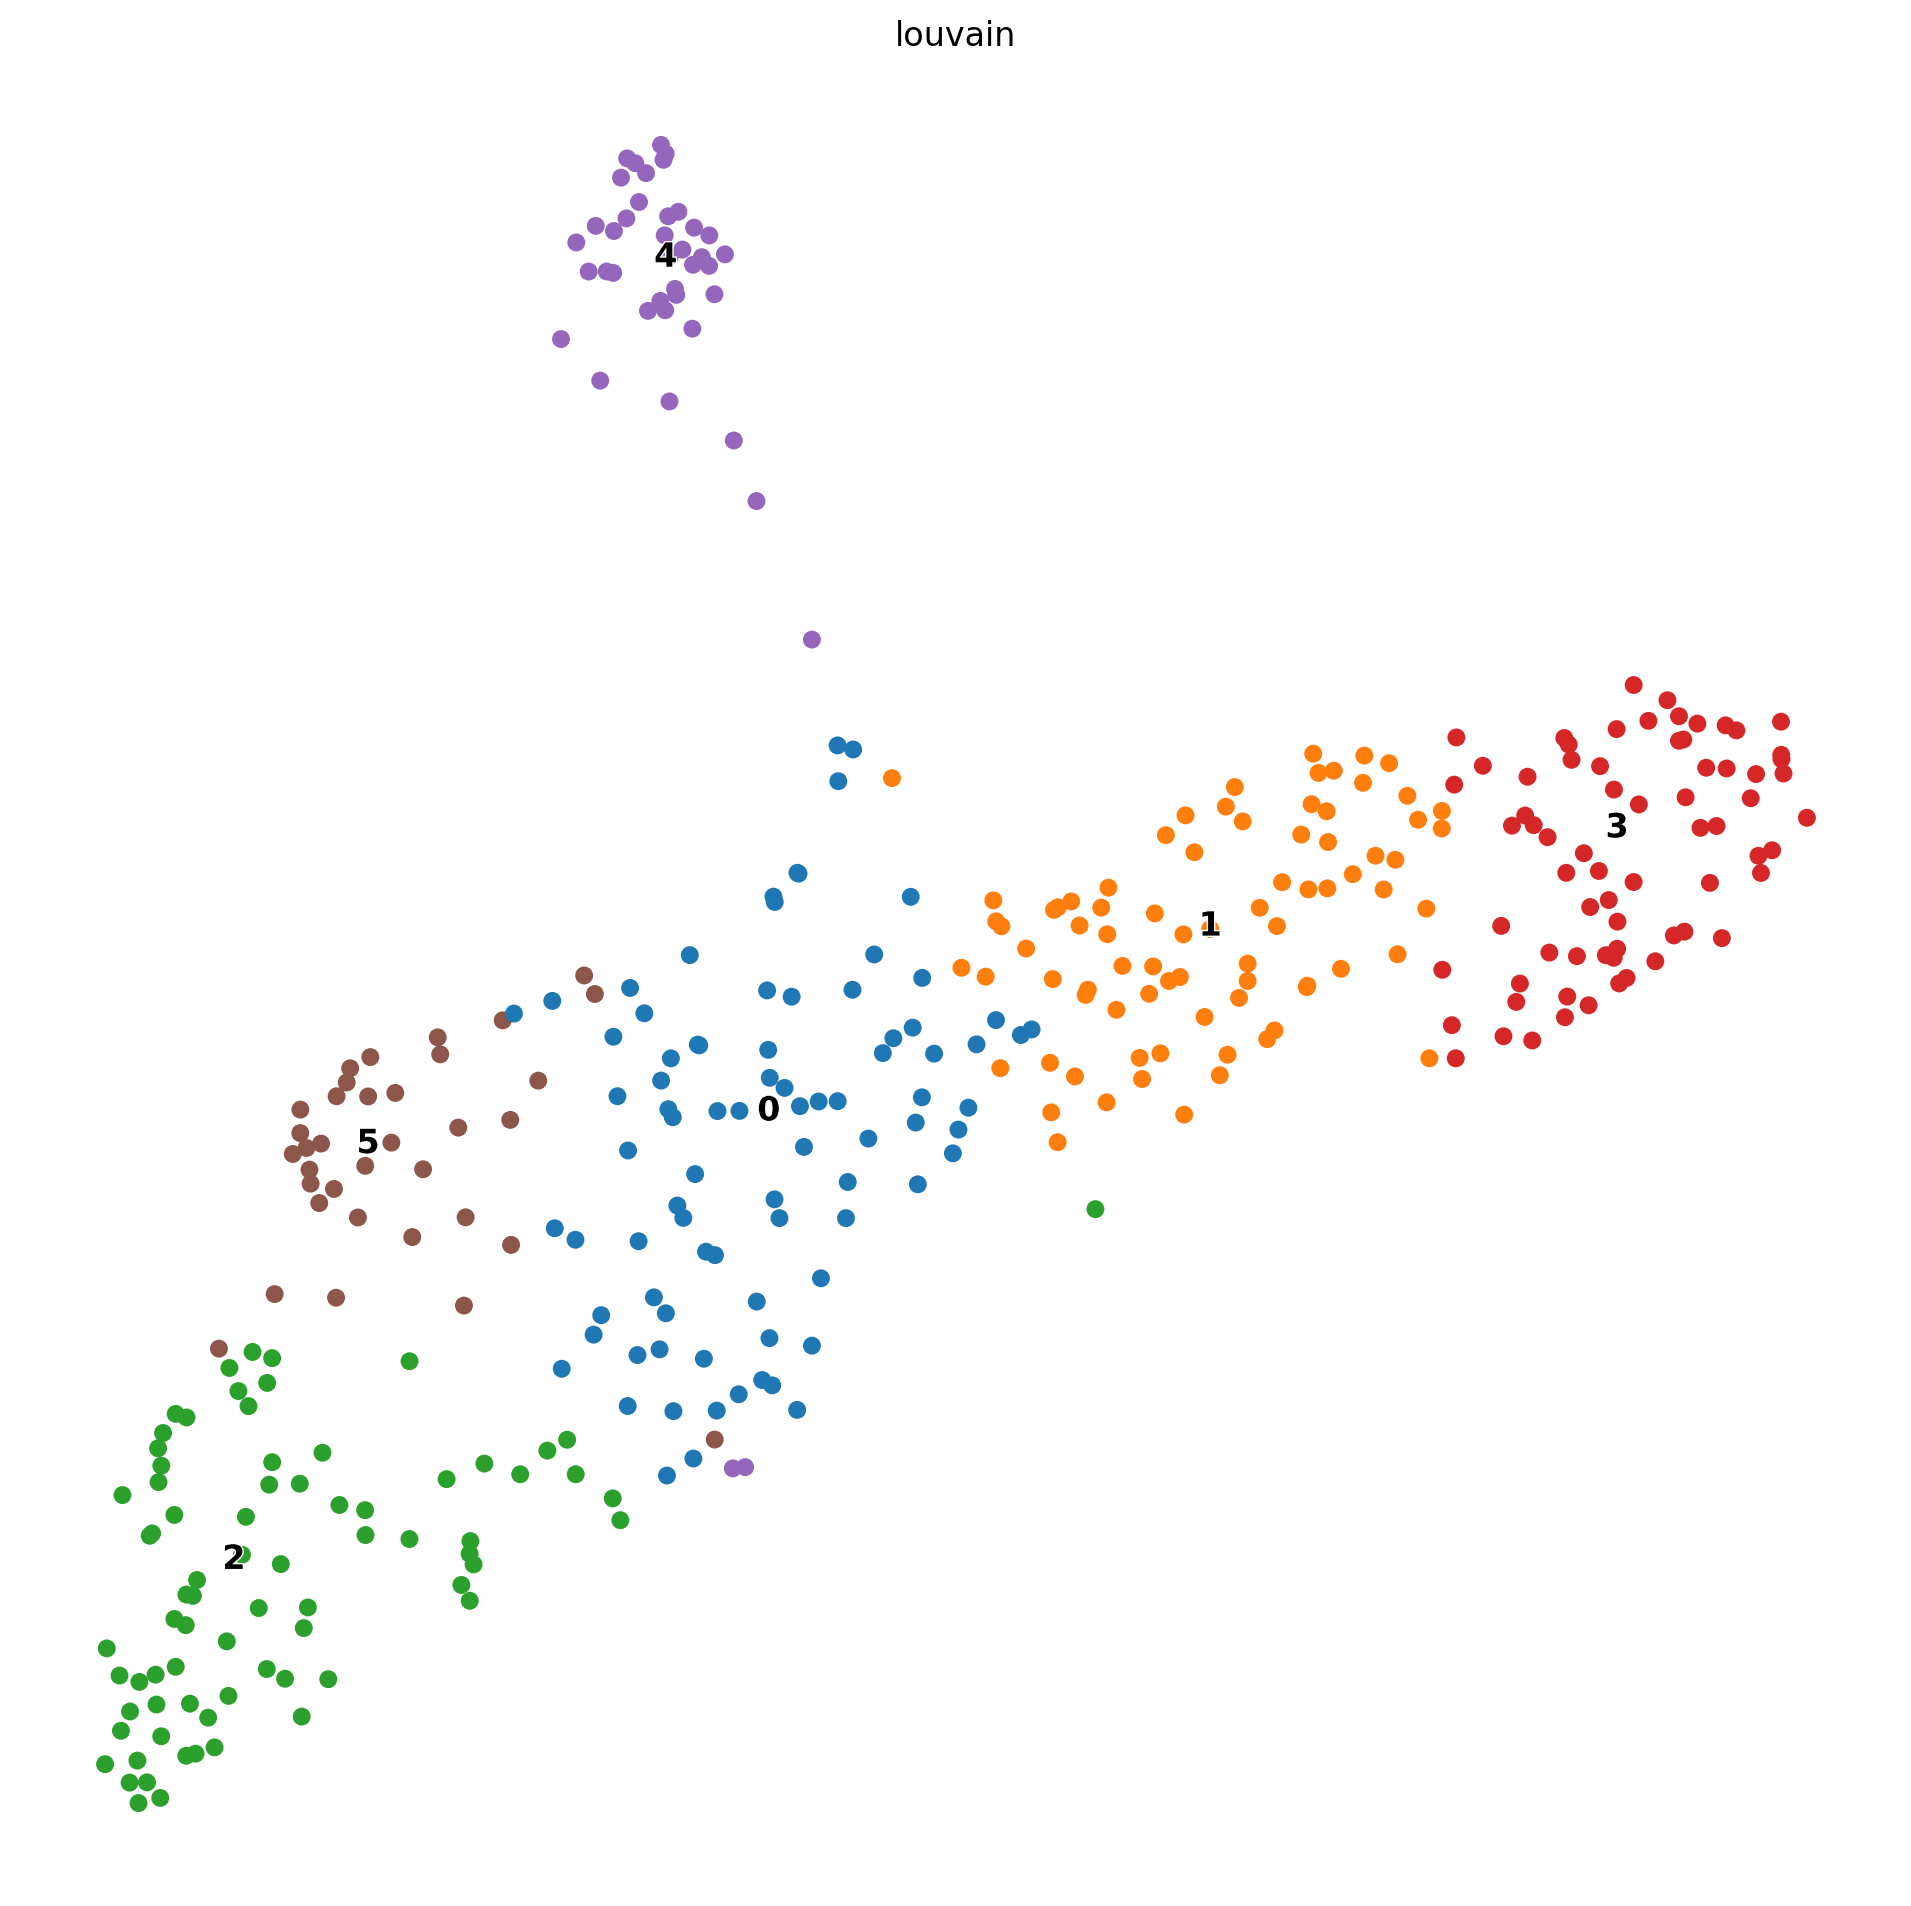

In [10]:
scv.tl.umap(adata, min_dist=0.2)
scv.pl.umap(adata)

- 事前知識(細胞種マーカーなど) を使用して大まかなcelltypeを推測
- 各クラスタとcelltypeの対比
    - 2 : SCPs
    - 0,1,5 : ブリッジ細胞
    - 3 : クロマフィン細胞
    - 4 : 交感神経芽細胞

<img src="figures/230201_img03.png" alt="230201_img03" style="width: 500px;"/>

<br />

- scv.pl.proportions
  - クラスタごとのspliced/unsplicedの割合を表示

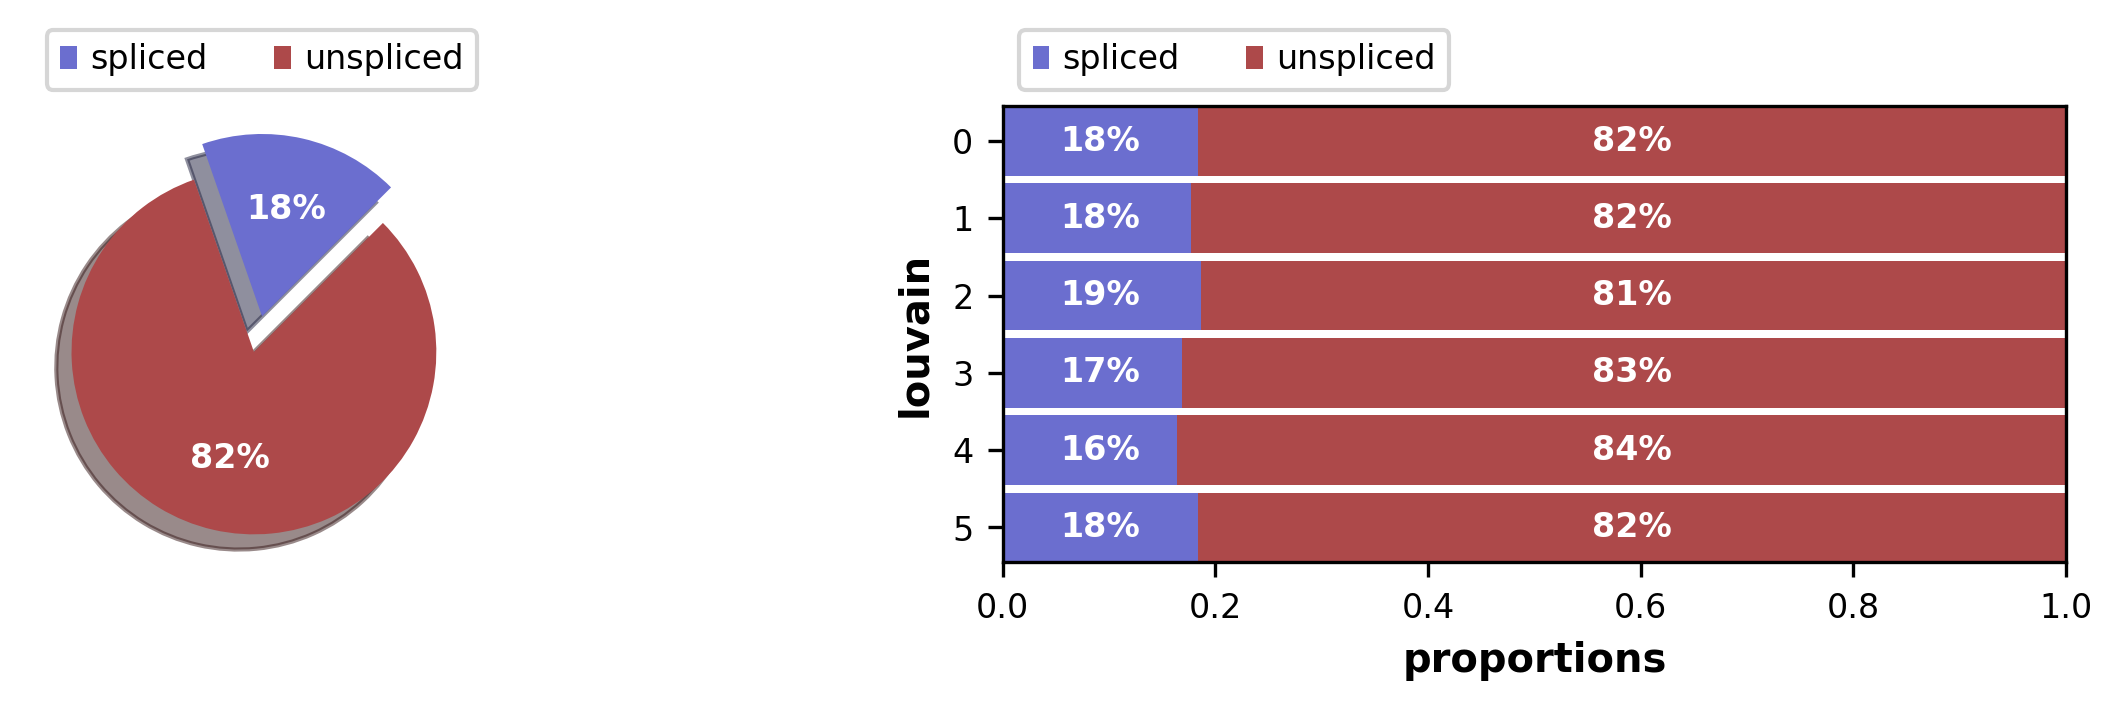

In [11]:
scv.pl.proportions(adata, groupby='louvain',dpi=150)

In [12]:
### save object for deterministic mode
adata_dt = adata.copy()
### save object for dynamical mode
adata_D = adata.copy()

#### 決定論的モデルでのVelocity推定 + 低次元埋め込み

In [34]:
scv.tl.velocity(adata_dt, mode='deterministic')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


- scv.tl.velocity_graph
  - cosine similarities に基づいて遷移確率行列を生成する

In [35]:
scv.tl.velocity_graph(adata_dt)

computing velocity graph (using 1/20 cores)


  0%|          | 0/384 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


- scv.pl.velocity_embedding_stream
  - 推定したvelocityがUMAP上に埋め込まれる

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


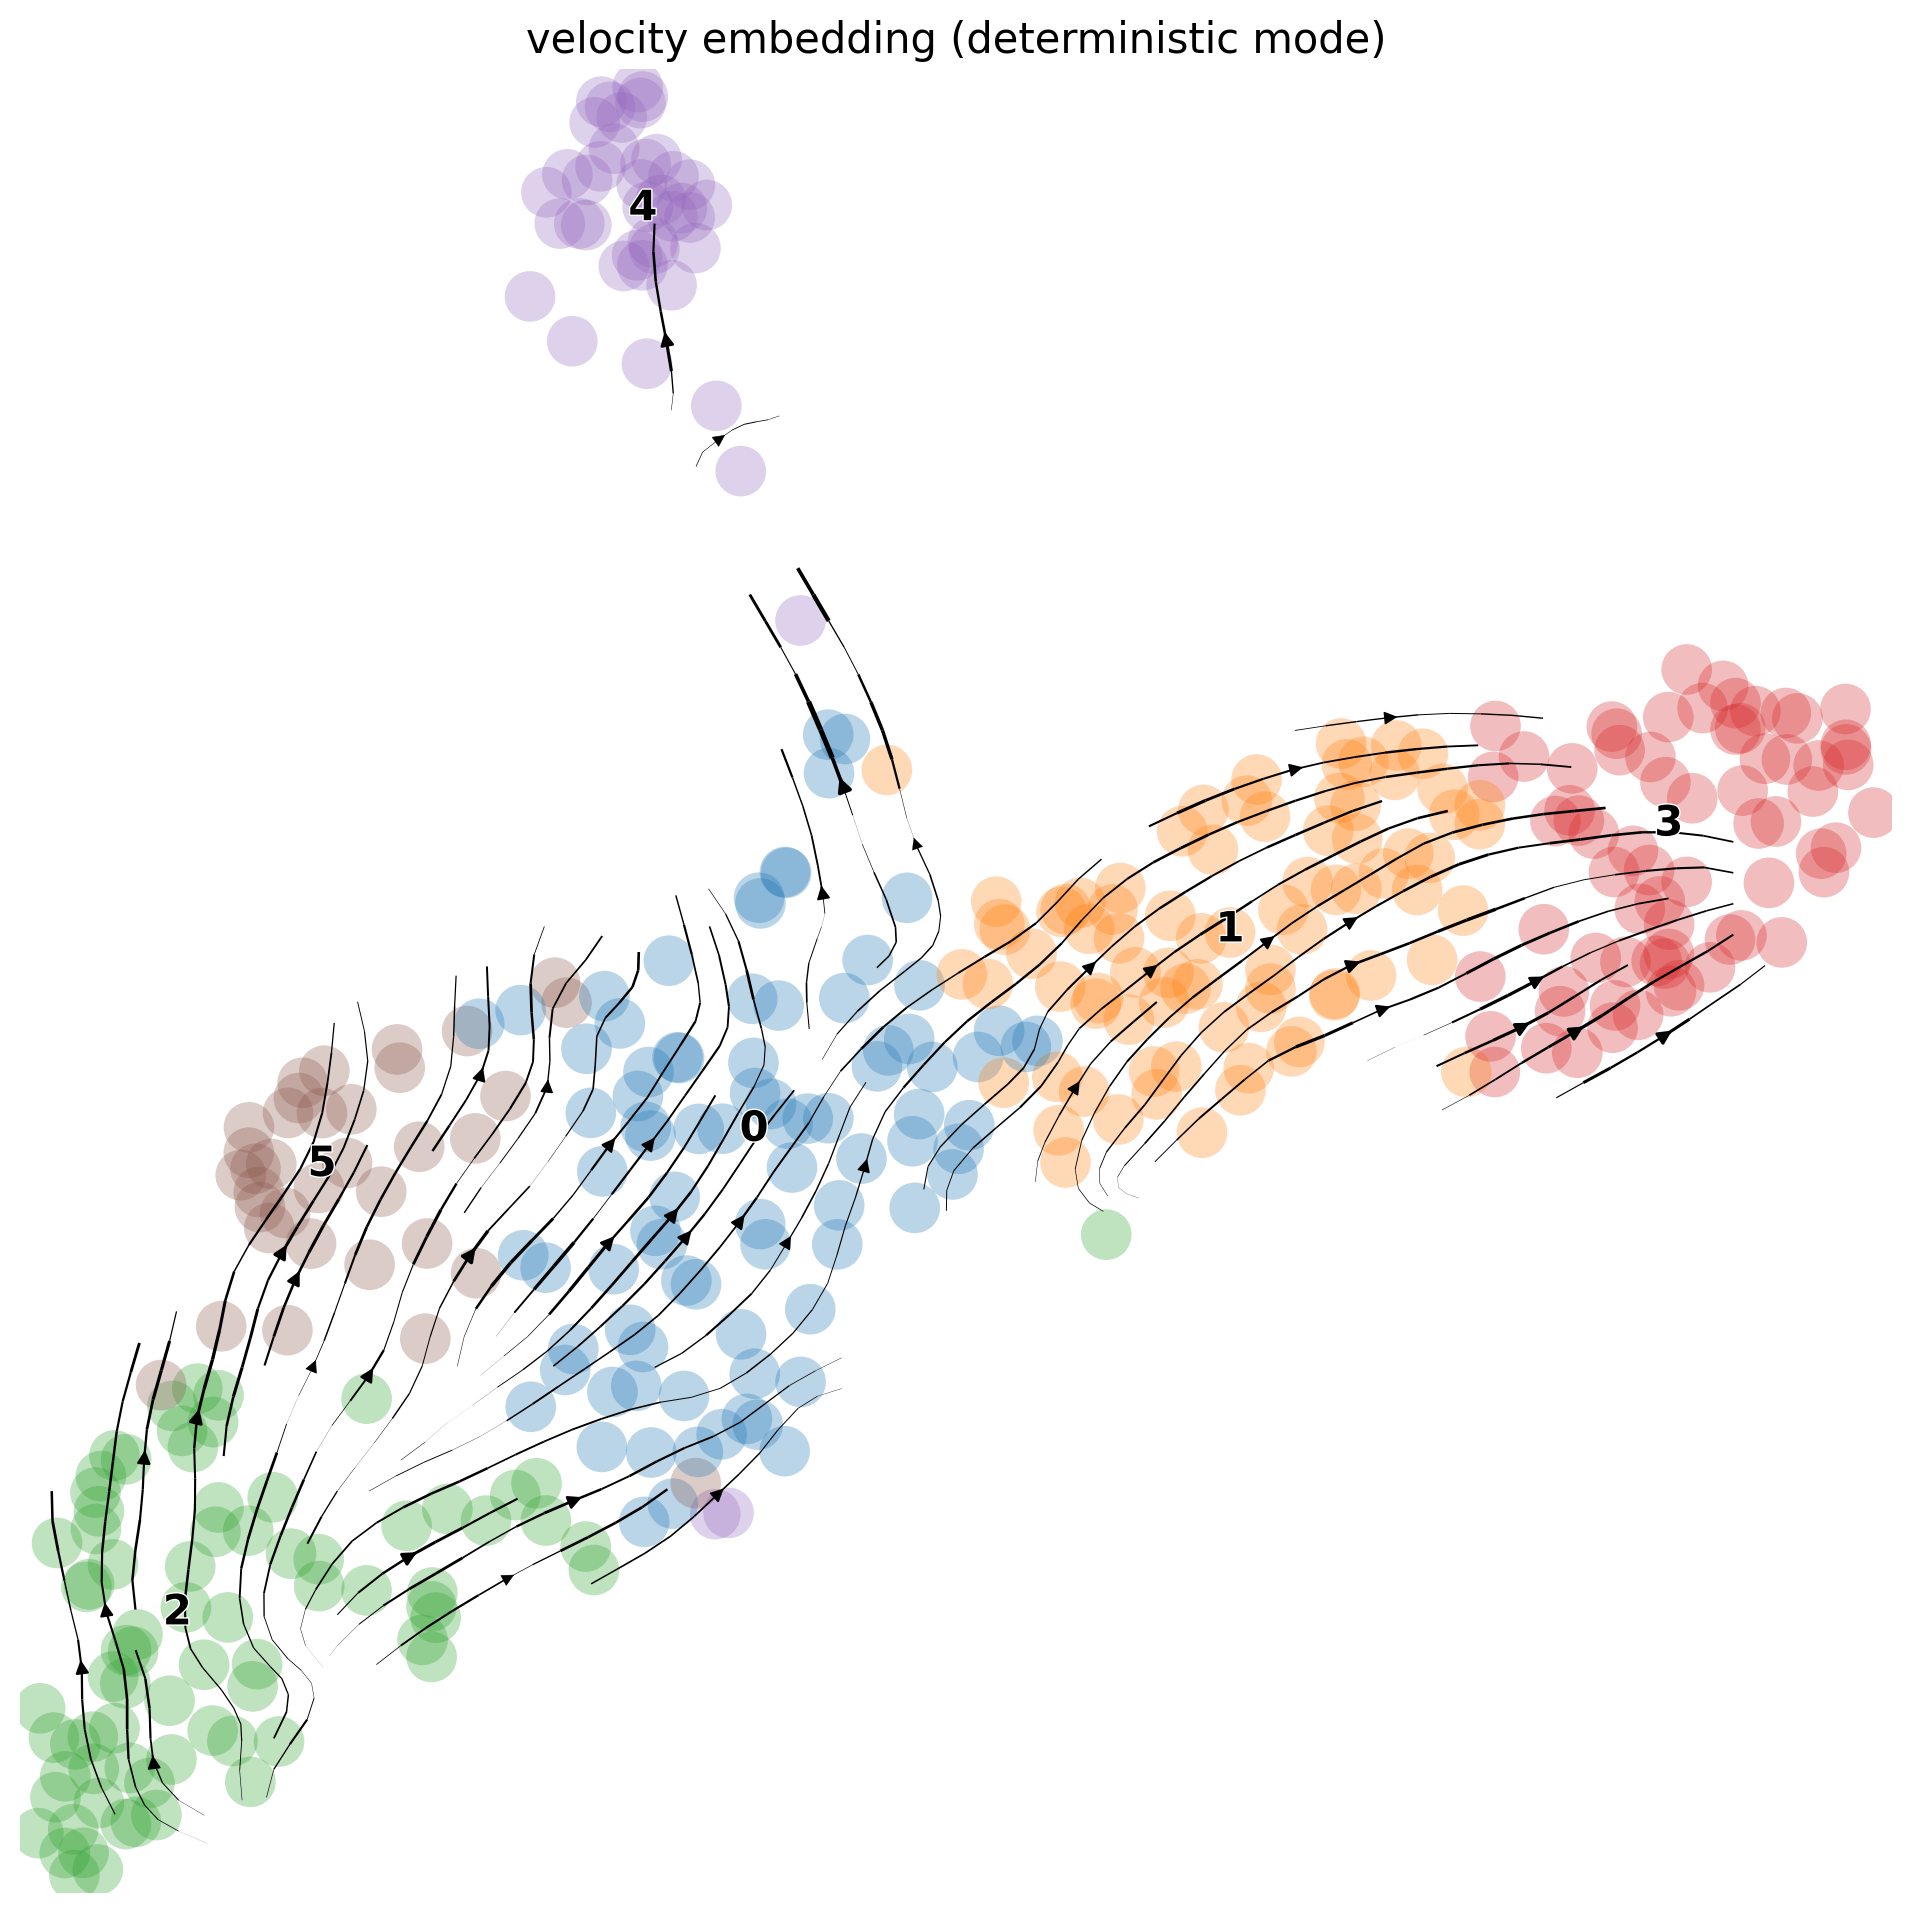

In [36]:
scv.pl.velocity_embedding_stream(adata_dt,basis="umap",title='velocity embedding (deterministic mode)',fontsize=15,legend_fontsize=15,min_mass=2)

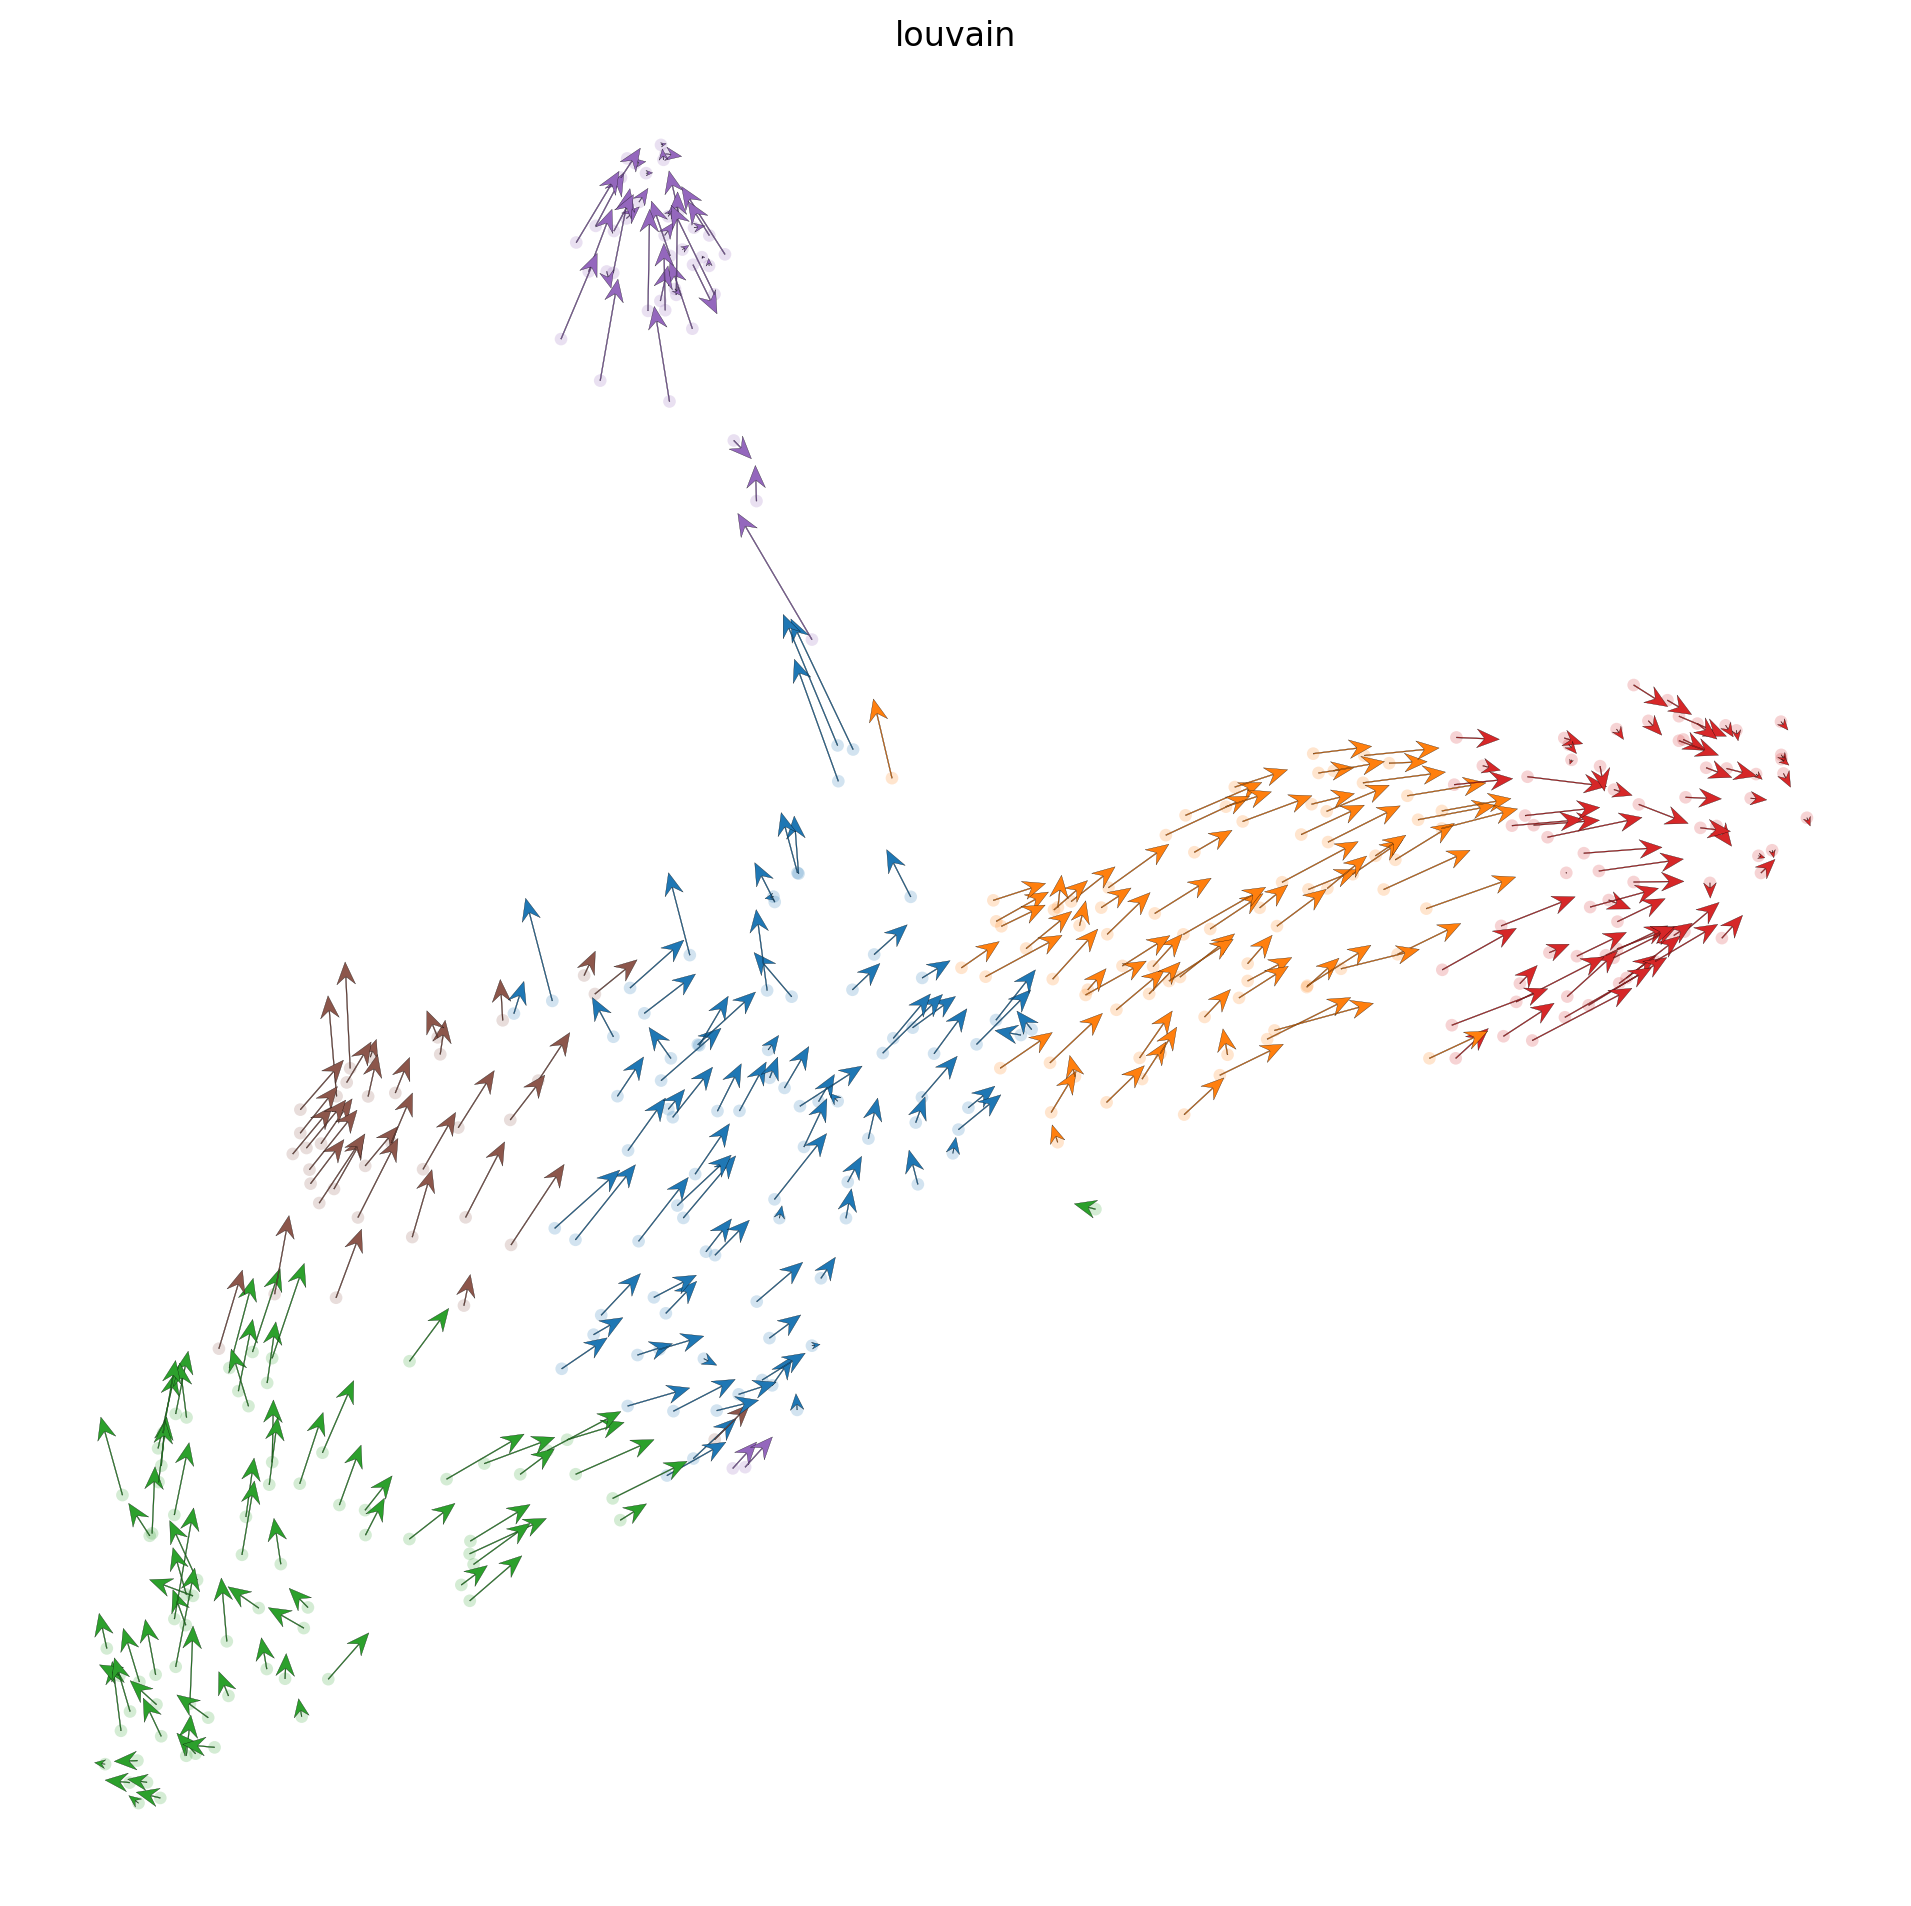

In [37]:
scv.pl.velocity_embedding(adata_dt, arrow_length=3, arrow_size=2)

- velocity length & confidenceの表示
  - length : 定常状態からの逸脱度合い、大きいほど発現促進or抑制傾向に振れている
  - confidence : velocityベクトルが隣接するvelocityとどのように相関するかを示し、信頼性の尺度

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


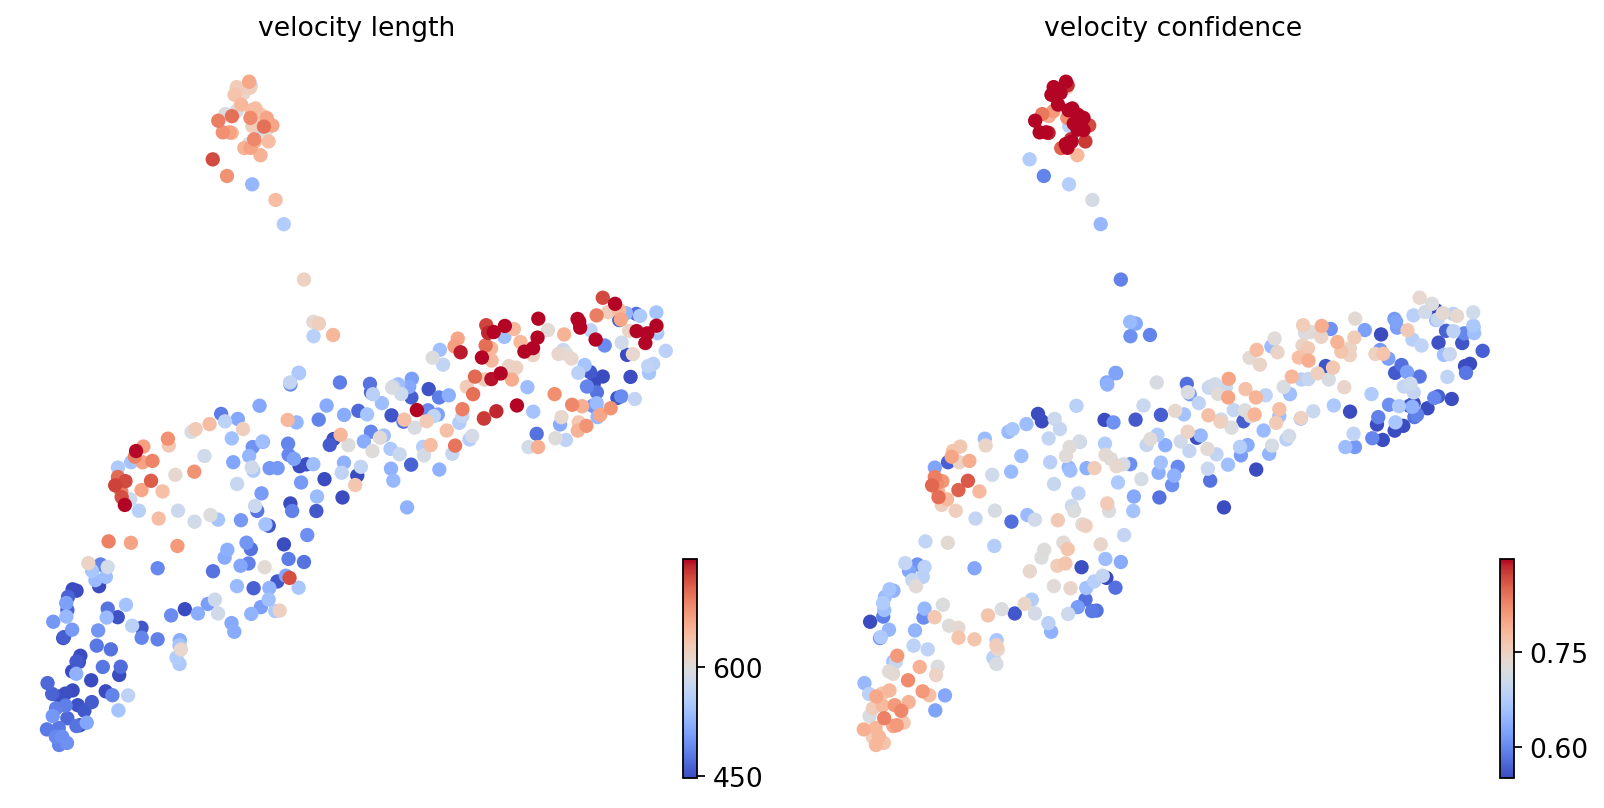

In [38]:
scv.tl.velocity_confidence(adata_dt)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata_dt, c=keys, cmap='coolwarm', perc=[5, 95])

In [39]:
df = adata_dt.obs.groupby('louvain')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

- **決定論的モデルのVelocity推定結果について**
  - 2(SCPs) から 3(クロマフィン細胞) に向けて、velocityのベクトルの方向は全体的に滑らか
  - velocity lengthは2(SCPs)の上にある5(ブリッジ細胞)で高くなっており、全体的に不均一な傾向
    - 4(交感神経芽細胞)以外は一つの大きな分化系譜を示すはずなので、velocity推定があまりうまくいっていない可能性がある

<br />
<hr>

#### 確率論的モデルでのVelocity推定 + 低次元埋め込み

In [13]:
scv.tl.velocity(adata, mode='stochastic')

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


- scv.tl.velocity_graphで遷移確率行列を計算

In [15]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/20 cores)


  0%|          | 0/384 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


- 確率論的モデルで推定したvelocityのUMAP上への埋め込み

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


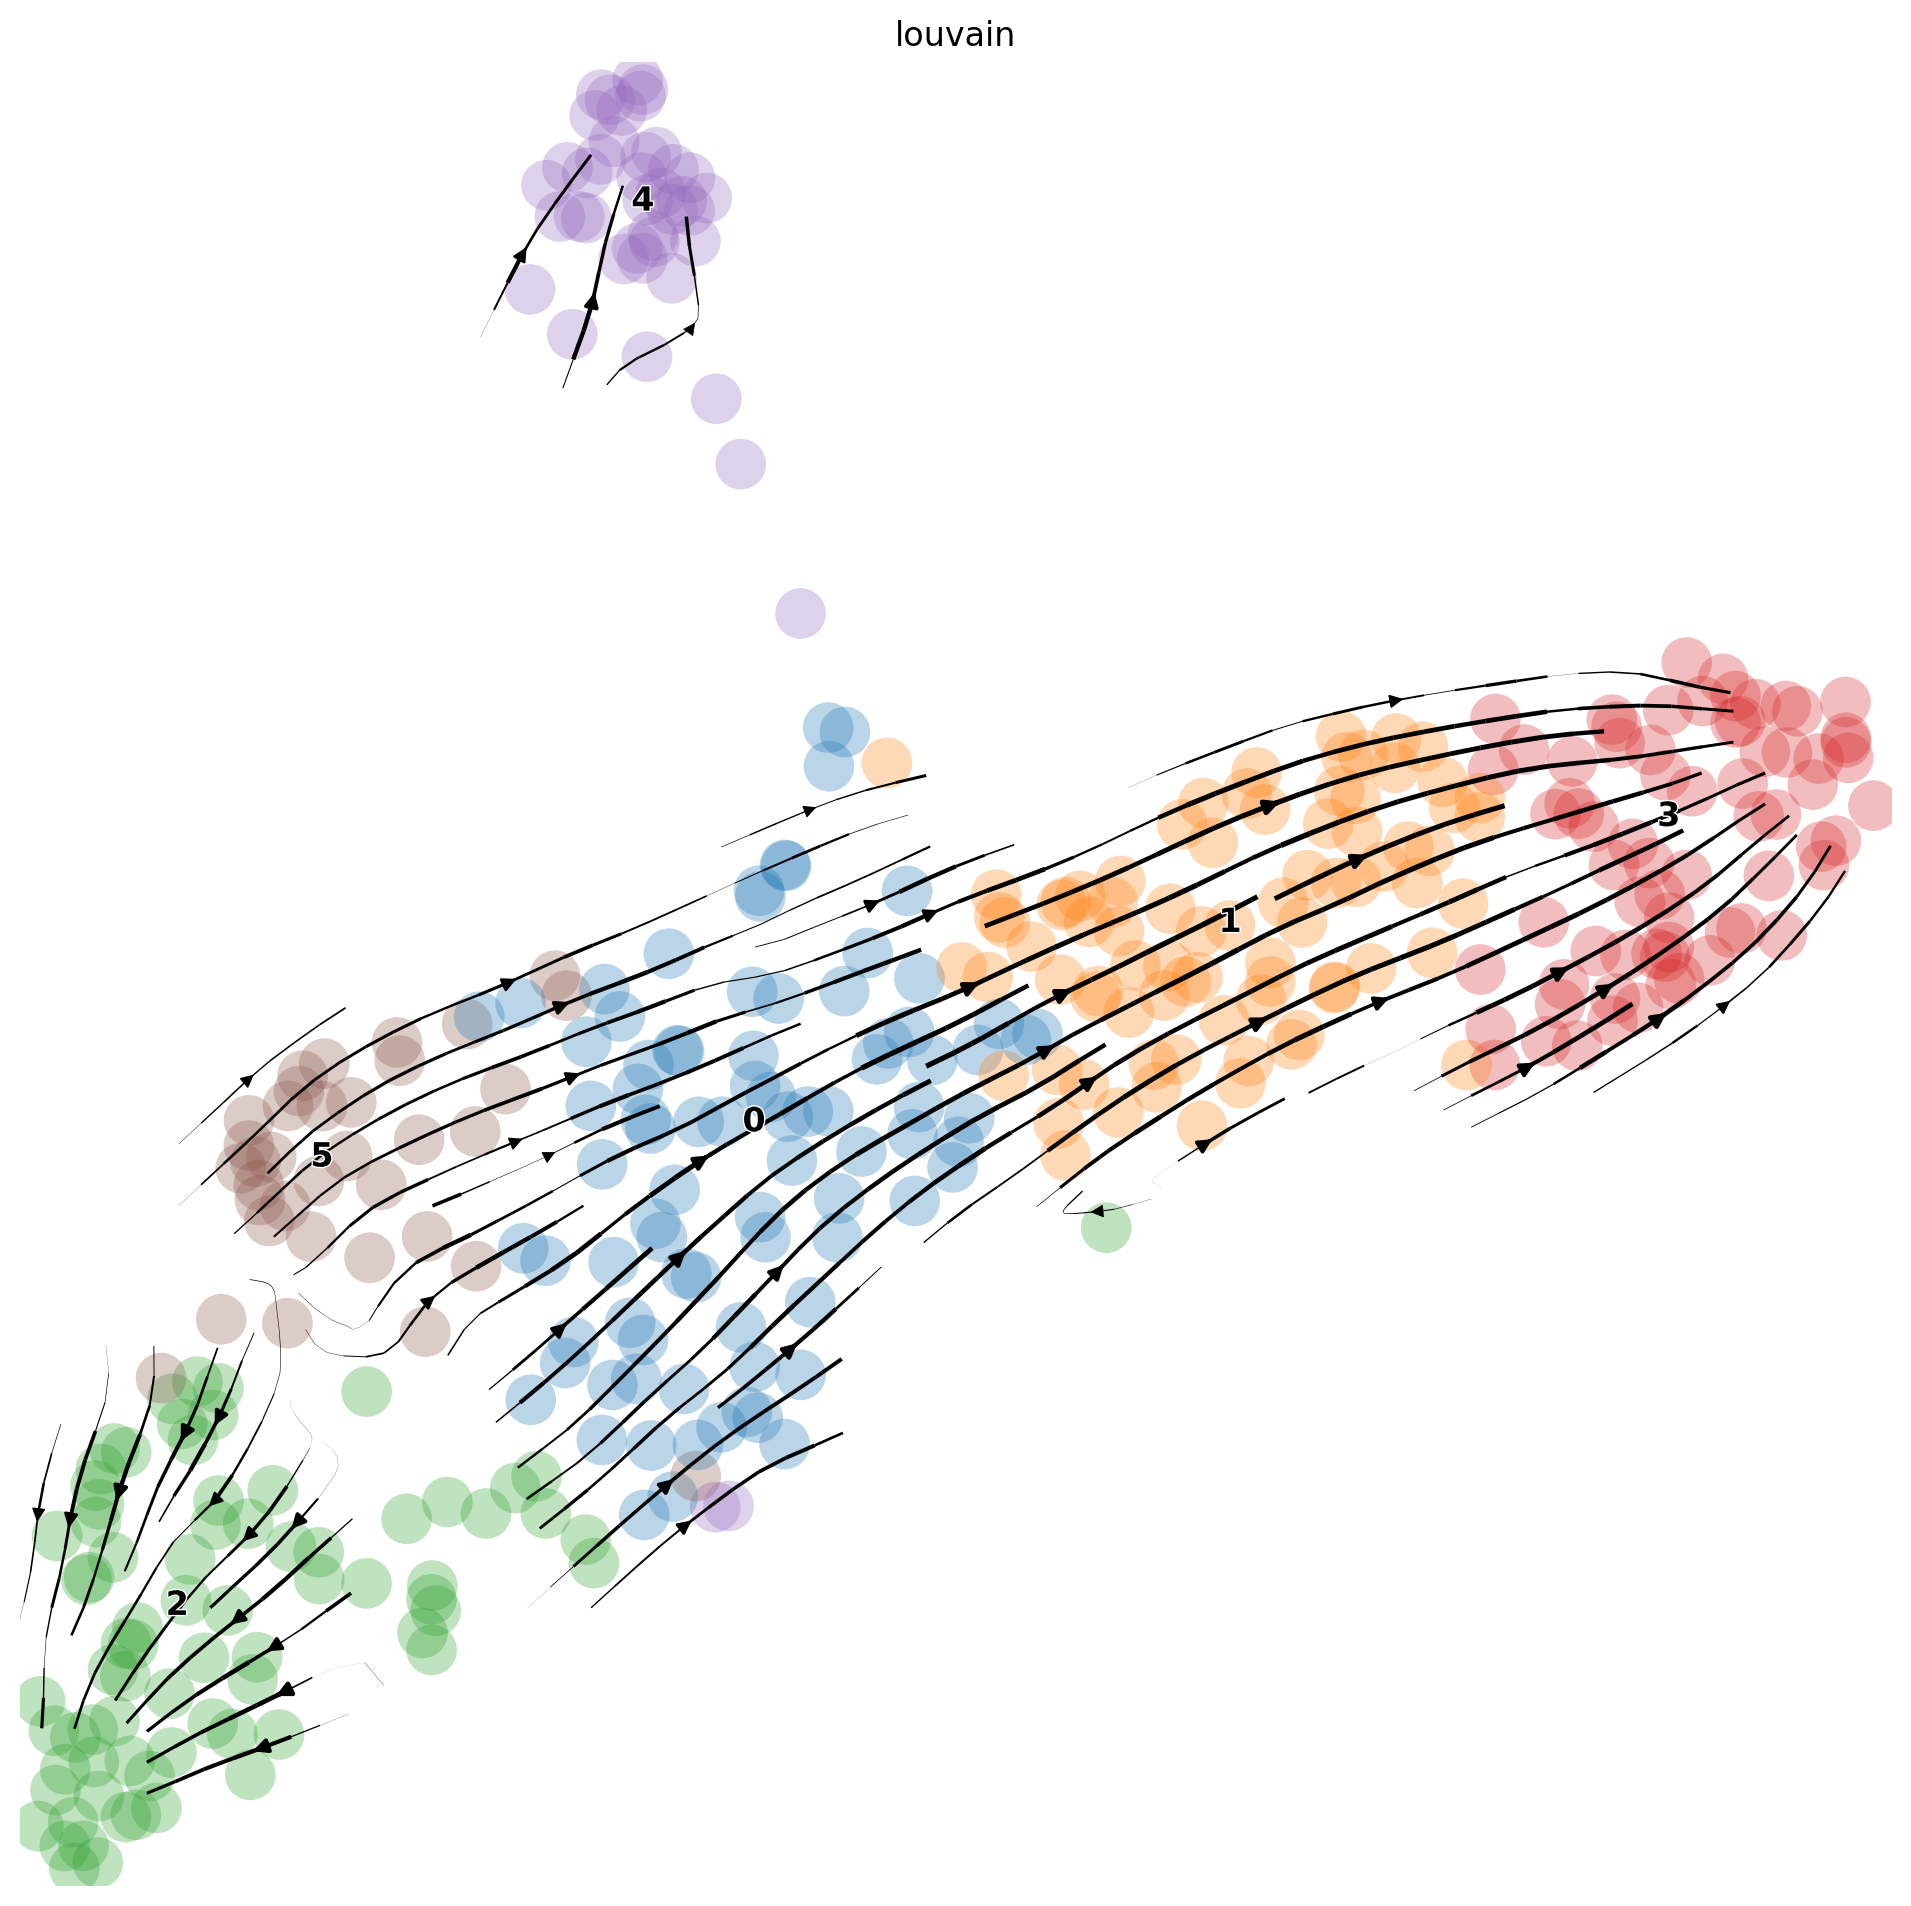

In [16]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

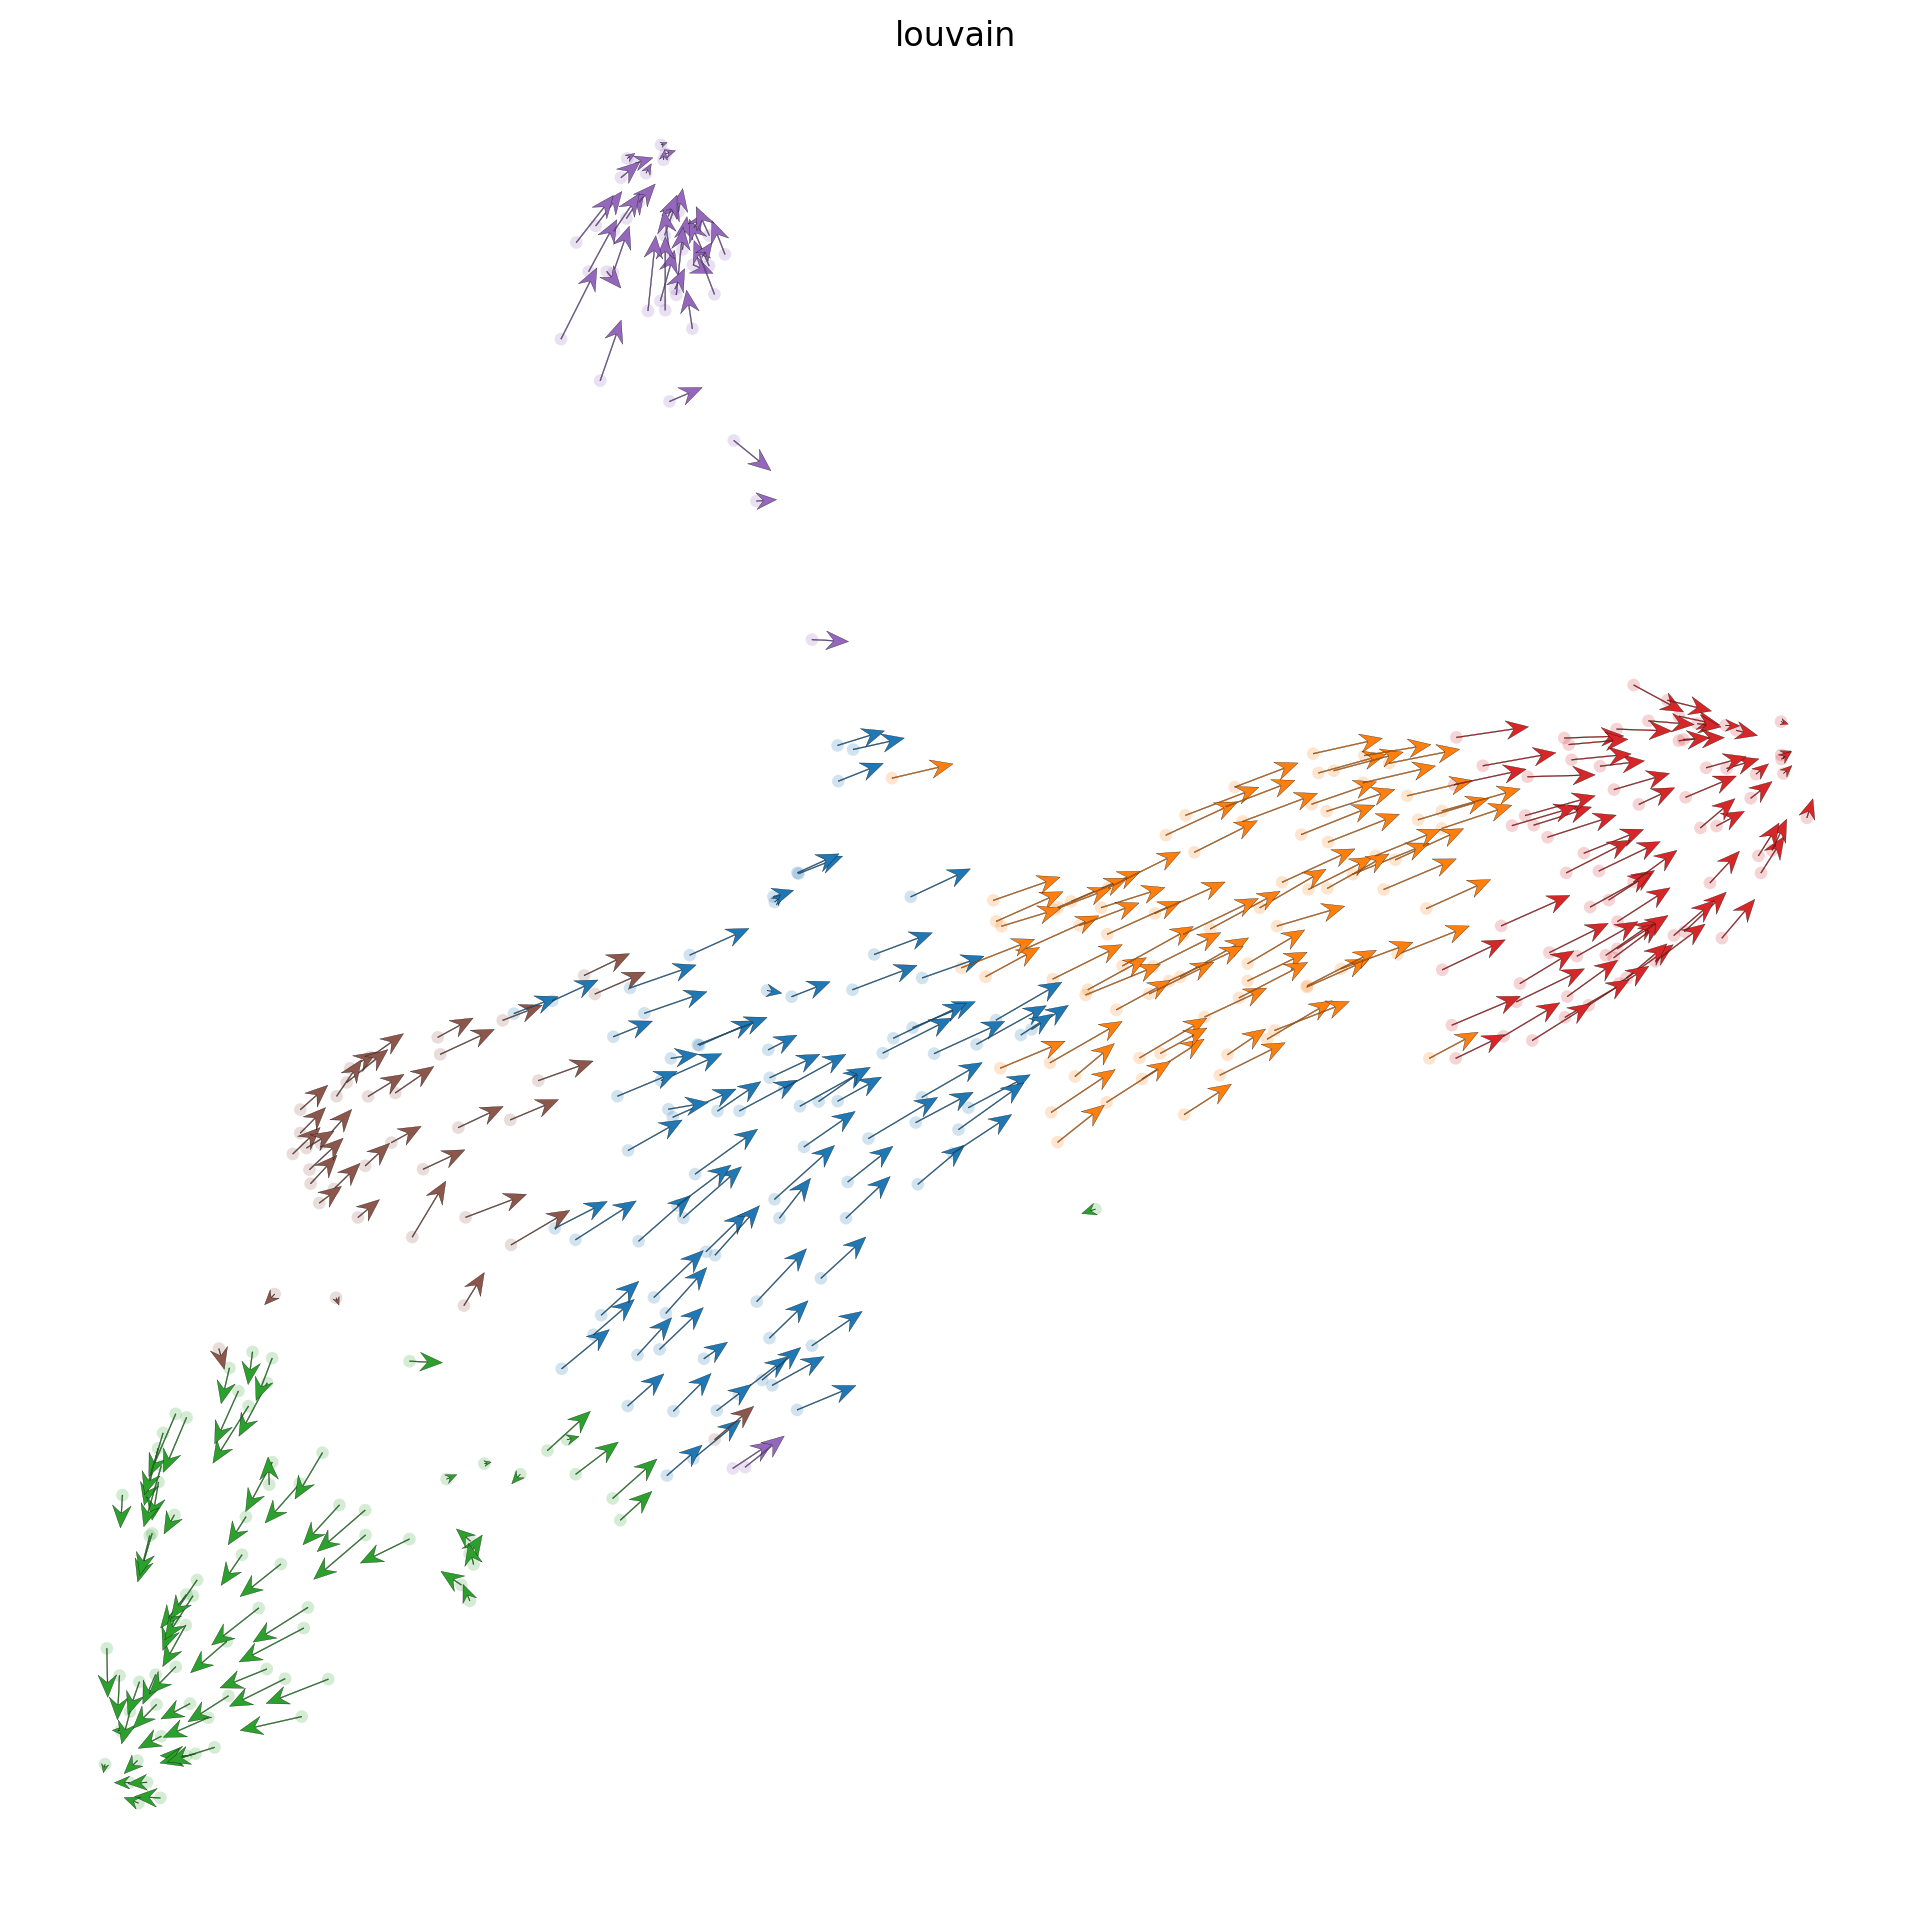

In [17]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2)

- velocity length & confidenceの表示

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


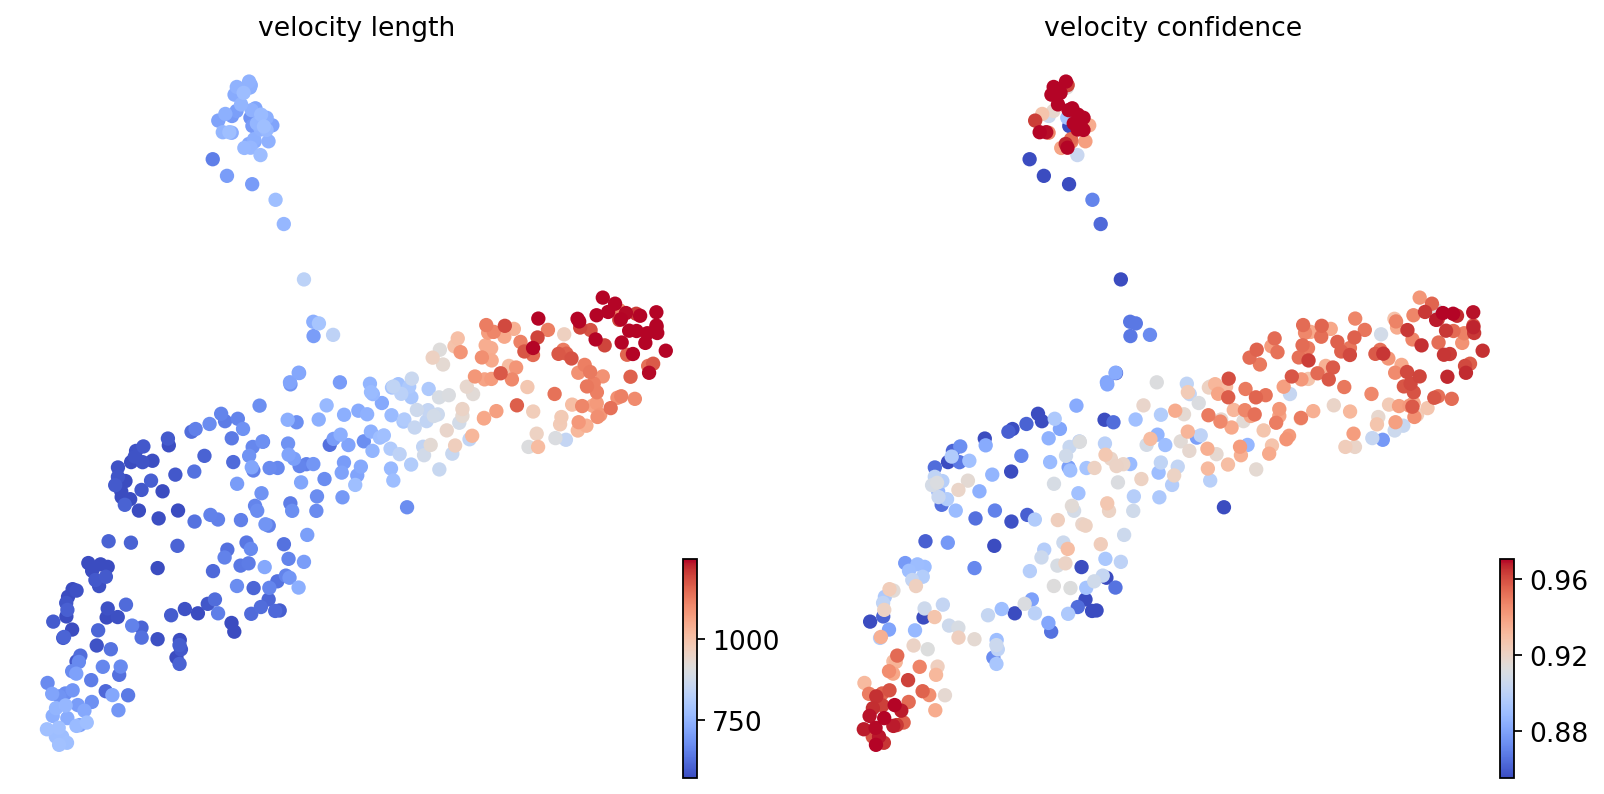

In [18]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

In [32]:
df = adata.obs.groupby('louvain')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

- **確率論的モデルのVelocity推定結果について**
  - 2(SCPs) は逆方向を示している
  - ブリッジ細胞から3(クロマフィン細胞) に向けて、velocityのベクトルの方向は滑らか
  - velocity lengthは1(ブリッジ細胞)から3(クロマフィン細胞)にかけて高くなっており、全体的に一貫している

- 未分化な細胞クラスタでは、velocityベクトルの向きが分化方向と異なったり、バラバラになることは度々みられる
  - 詳細な解析は確率論的モデルの結果を用いて進める

### Identify important genes
  - 推定されたベクトルフィールドの解釈に有用な遺伝子を同定する
  - クラスター特異的なvelocityを持ち、他の集団と比較して有意である遺伝子を検定する

- scv.tl.rank_velocity_genes
  - differential velocity t-test を実行し、各クラスタの遺伝子ランキングを出力する
  - ランキング上位の遺伝子をクラスタごとに表示する

In [19]:
scv.tl.rank_velocity_genes(adata, groupby='louvain', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


0              1                   2        3        4      5
0   Setbp1        Nup62cl               Ptprm   Piwil1      Kmo  Cep55
1    Sox10        Tmprss2             Fam169a  Gm14696   Elavl2   Xkr7
2     Nmt1        Dnaaf6b  ENSMUSG00000120897     Sptb  Slc7a14    Ogt
3  Plekhg1  4930432E11Rik               Lrig1  Plekhg3      Tnr  Cers5
4    Grik3          Zfpm2              Tcf7l1    Prr19    Elmo1   Lifr

- 上位遺伝子の相図

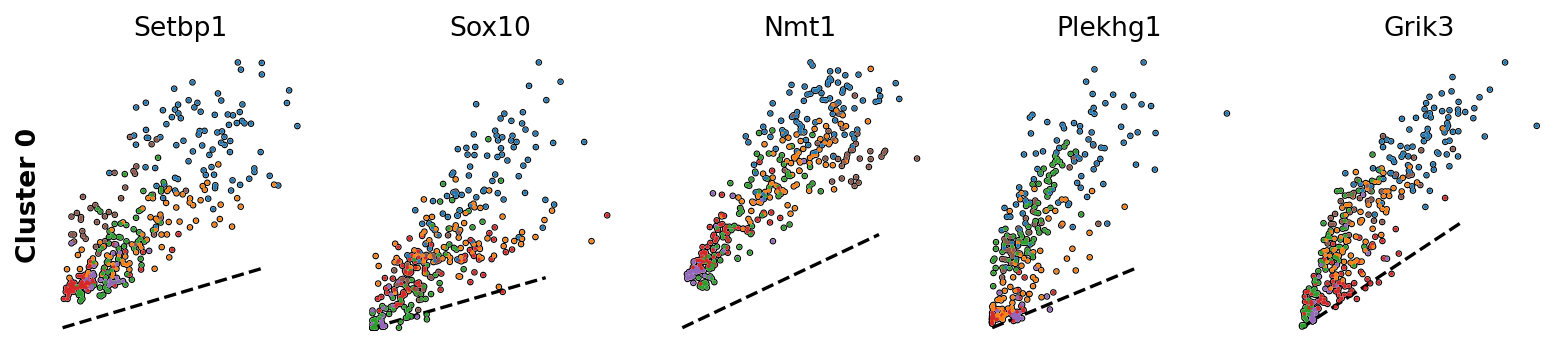

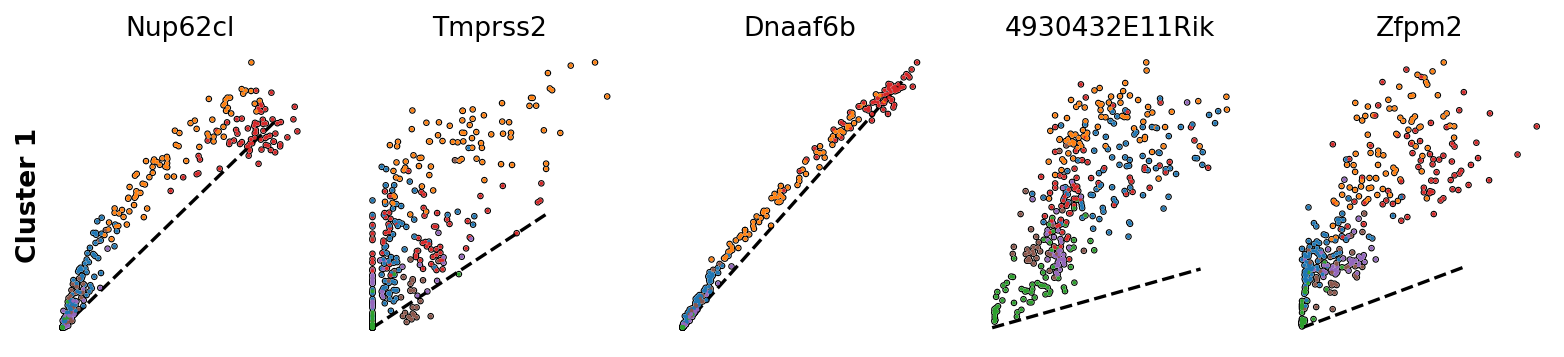

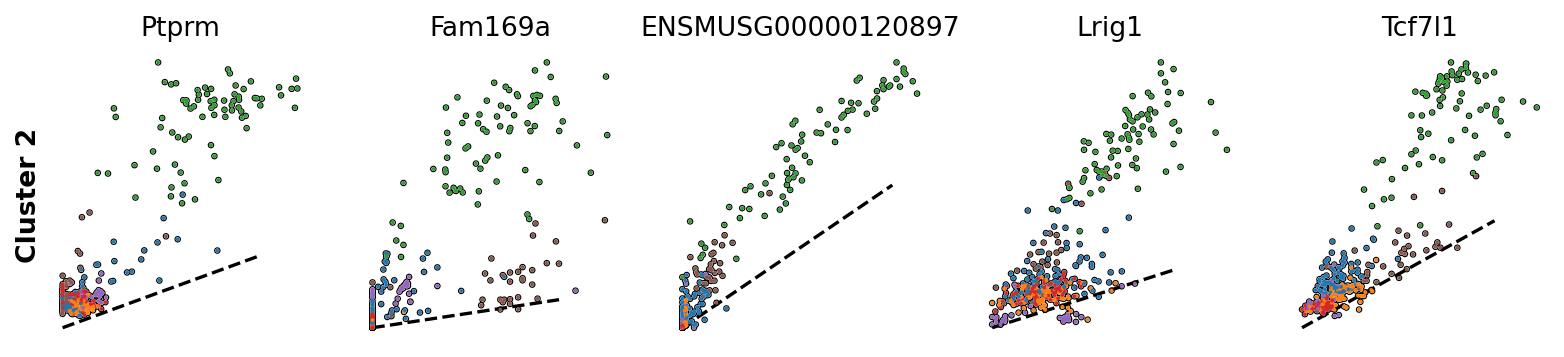

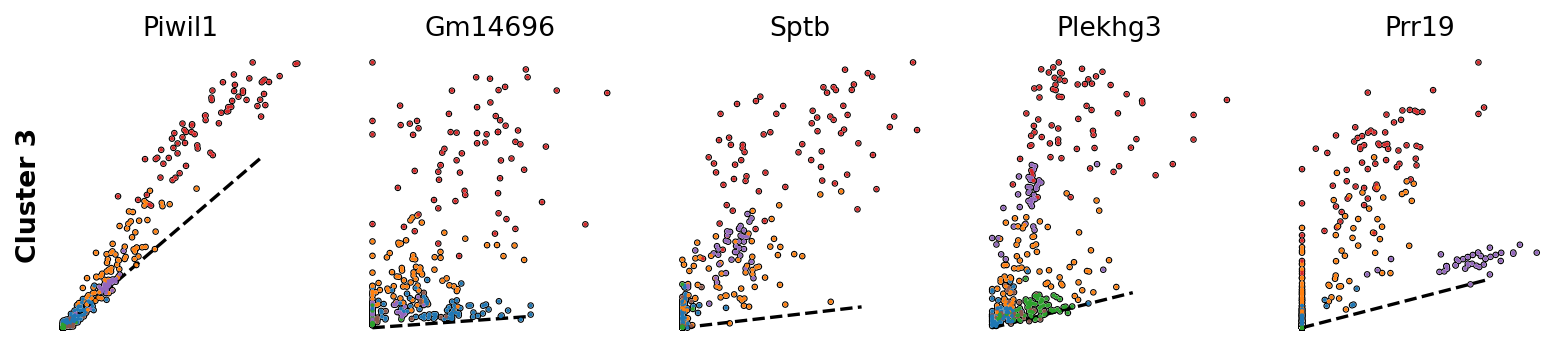

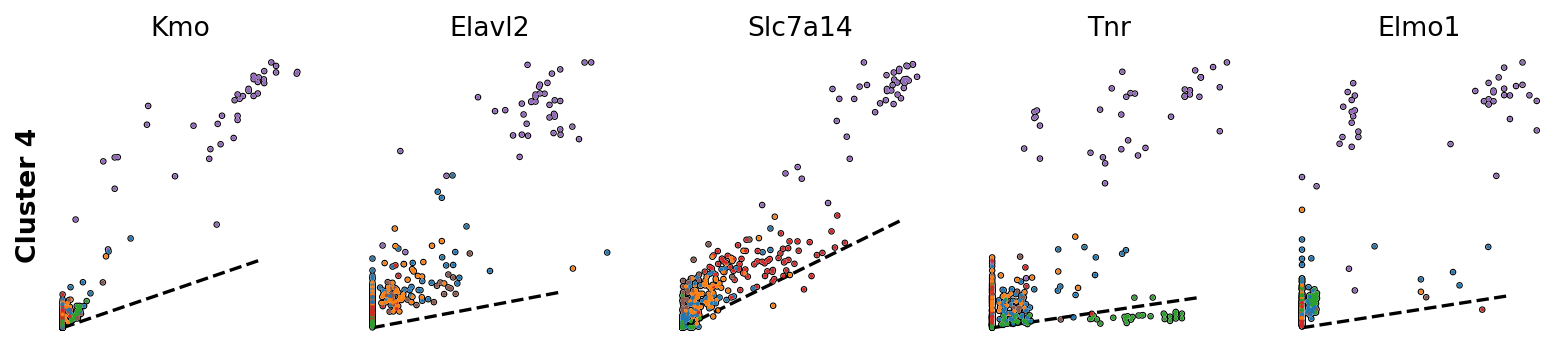

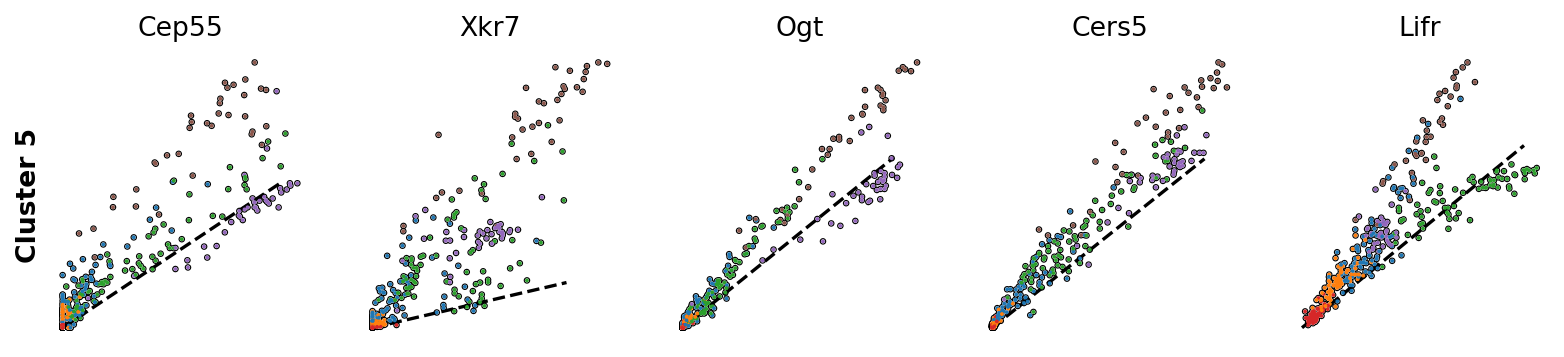

In [20]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='0, 1, 2, 3, 4, 5')

scv.pl.scatter(adata, df['0'][:5], ylabel='Cluster 0', **kwargs)
scv.pl.scatter(adata, df['1'][:5], ylabel='Cluster 1', **kwargs)
scv.pl.scatter(adata, df['2'][:5], ylabel='Cluster 2', **kwargs)
scv.pl.scatter(adata, df['3'][:5], ylabel='Cluster 3', **kwargs)
scv.pl.scatter(adata, df['4'][:5], ylabel='Cluster 4', **kwargs)
scv.pl.scatter(adata, df['5'][:5], ylabel='Cluster 5', **kwargs)

- ランク1の遺伝子について、velocity lengthと発現量プロット

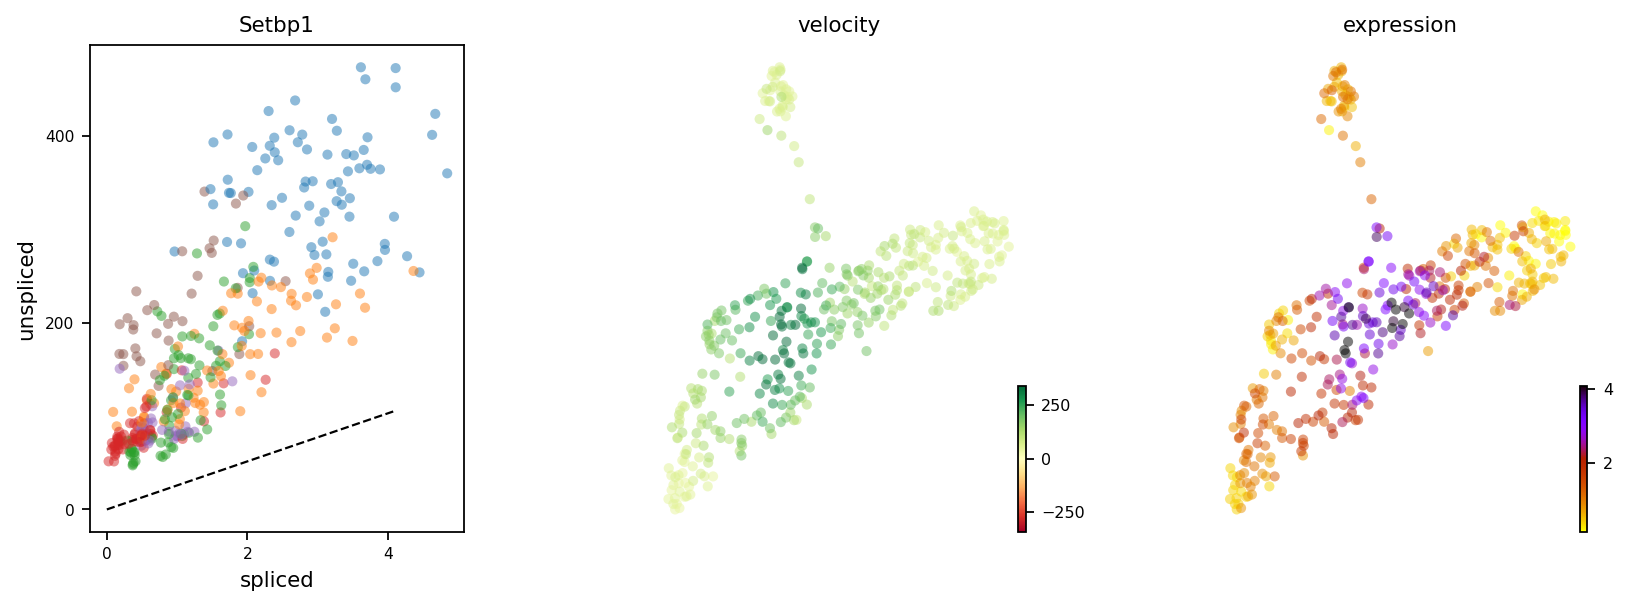

In [25]:
scv.pl.velocity(adata, var_names=['Setbp1'], color='louvain', dpi=200)

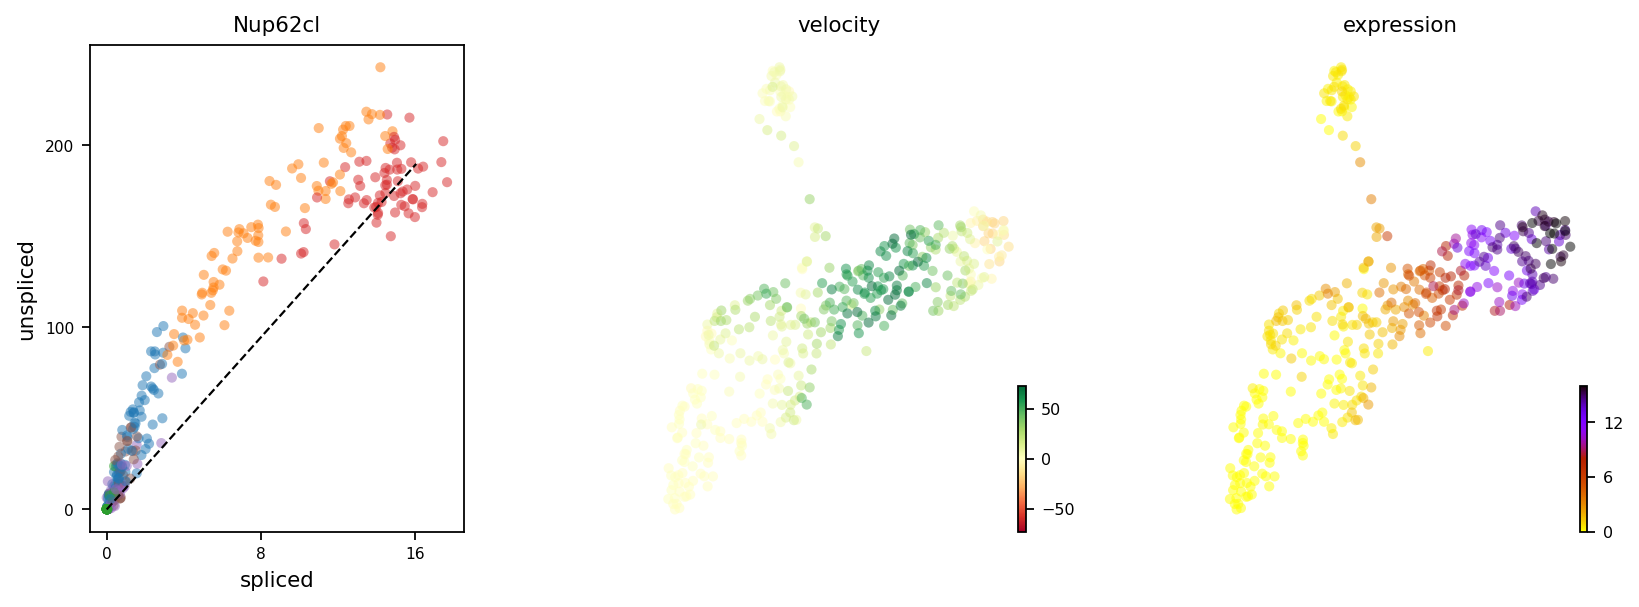

In [26]:
scv.pl.velocity(adata, var_names=['Nup62cl'], color='louvain', dpi=200)

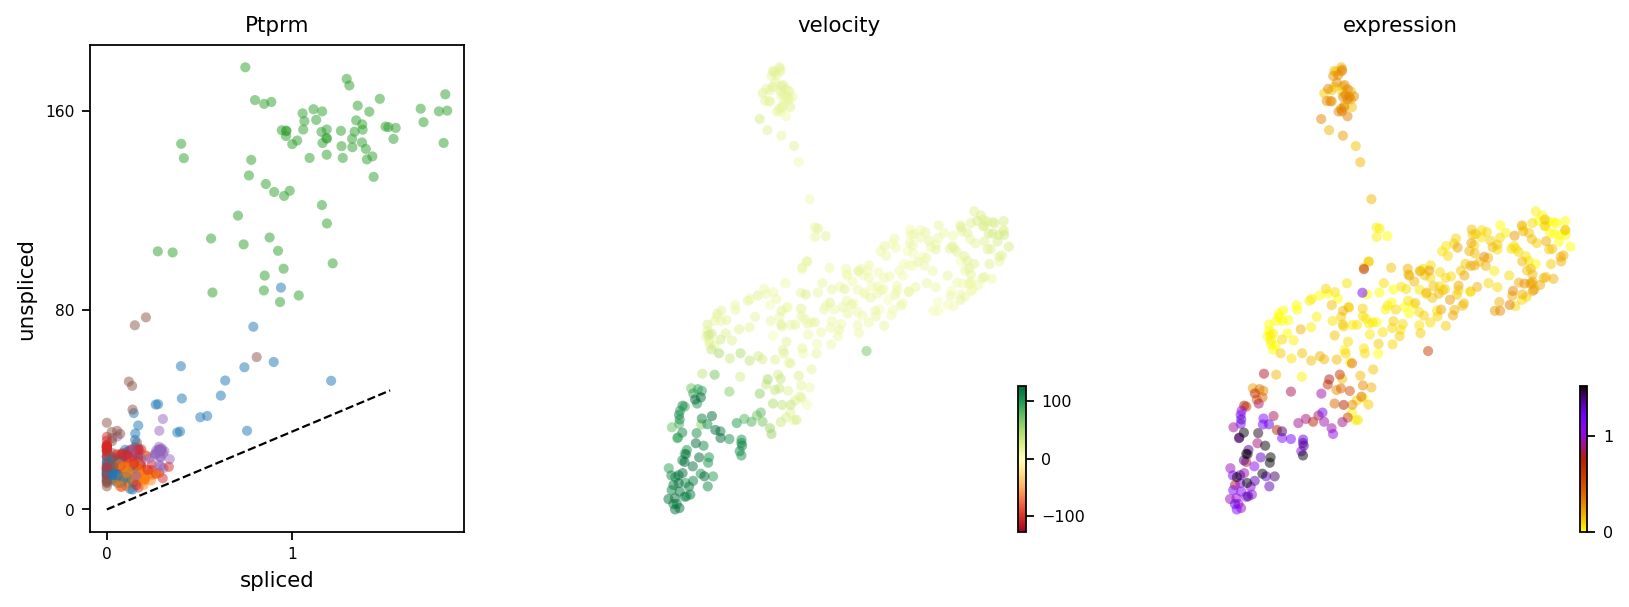

In [27]:
scv.pl.velocity(adata, var_names=['Ptprm'], color='louvain', dpi=200)

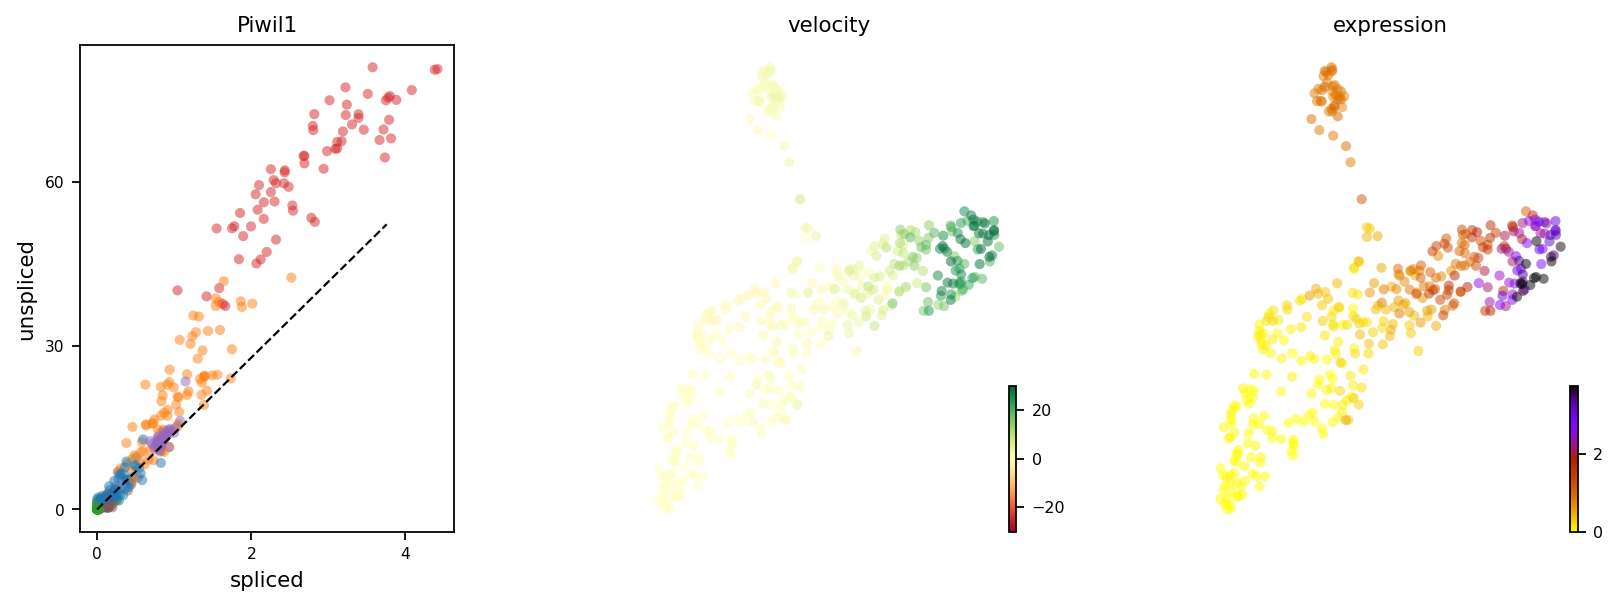

In [29]:
scv.pl.velocity(adata, var_names=['Piwil1'], color='louvain', dpi=200)

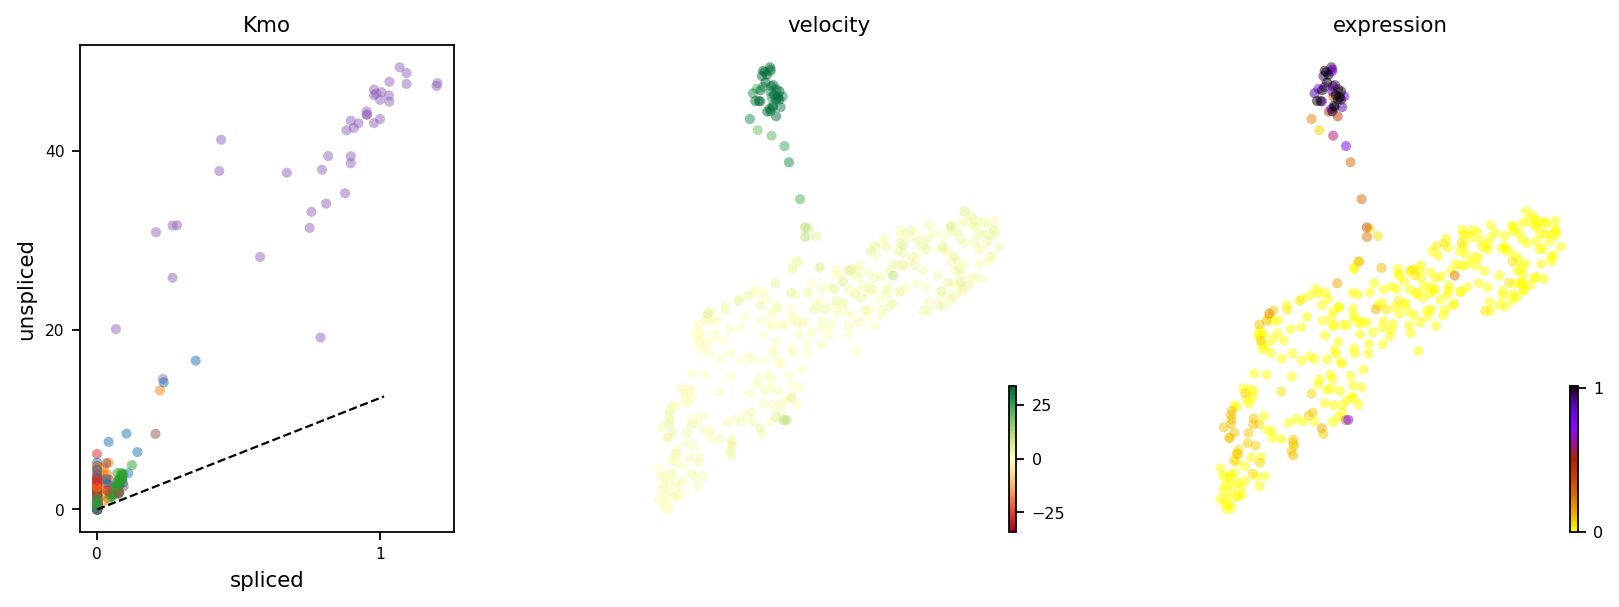

In [30]:
scv.pl.velocity(adata, var_names=['Kmo'], color='louvain', dpi=200)

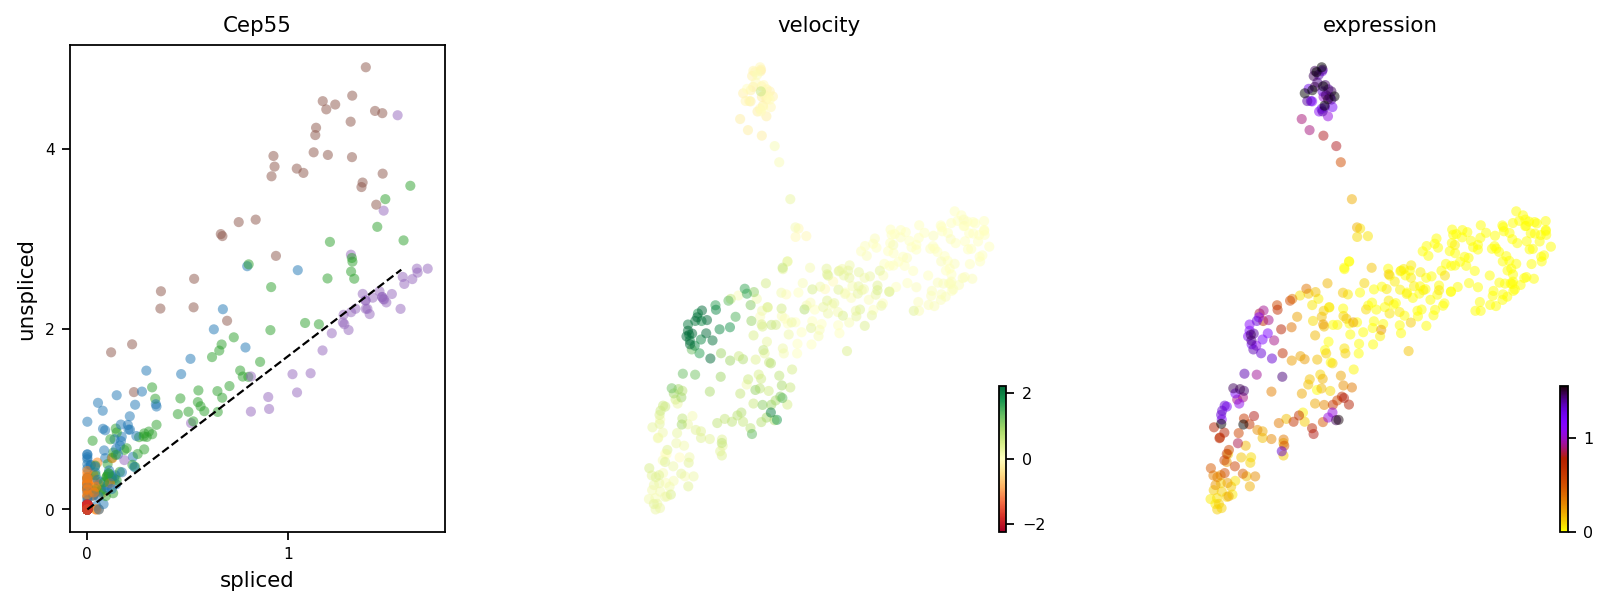

In [31]:
scv.pl.velocity(adata, var_names=['Cep55'], color='louvain', dpi=200)

### velocity pseudotime
  - ルート細胞を暗黙的に推定し、グラフ上のランダムウォークに基づいた各細胞までの距離測定を行う

computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


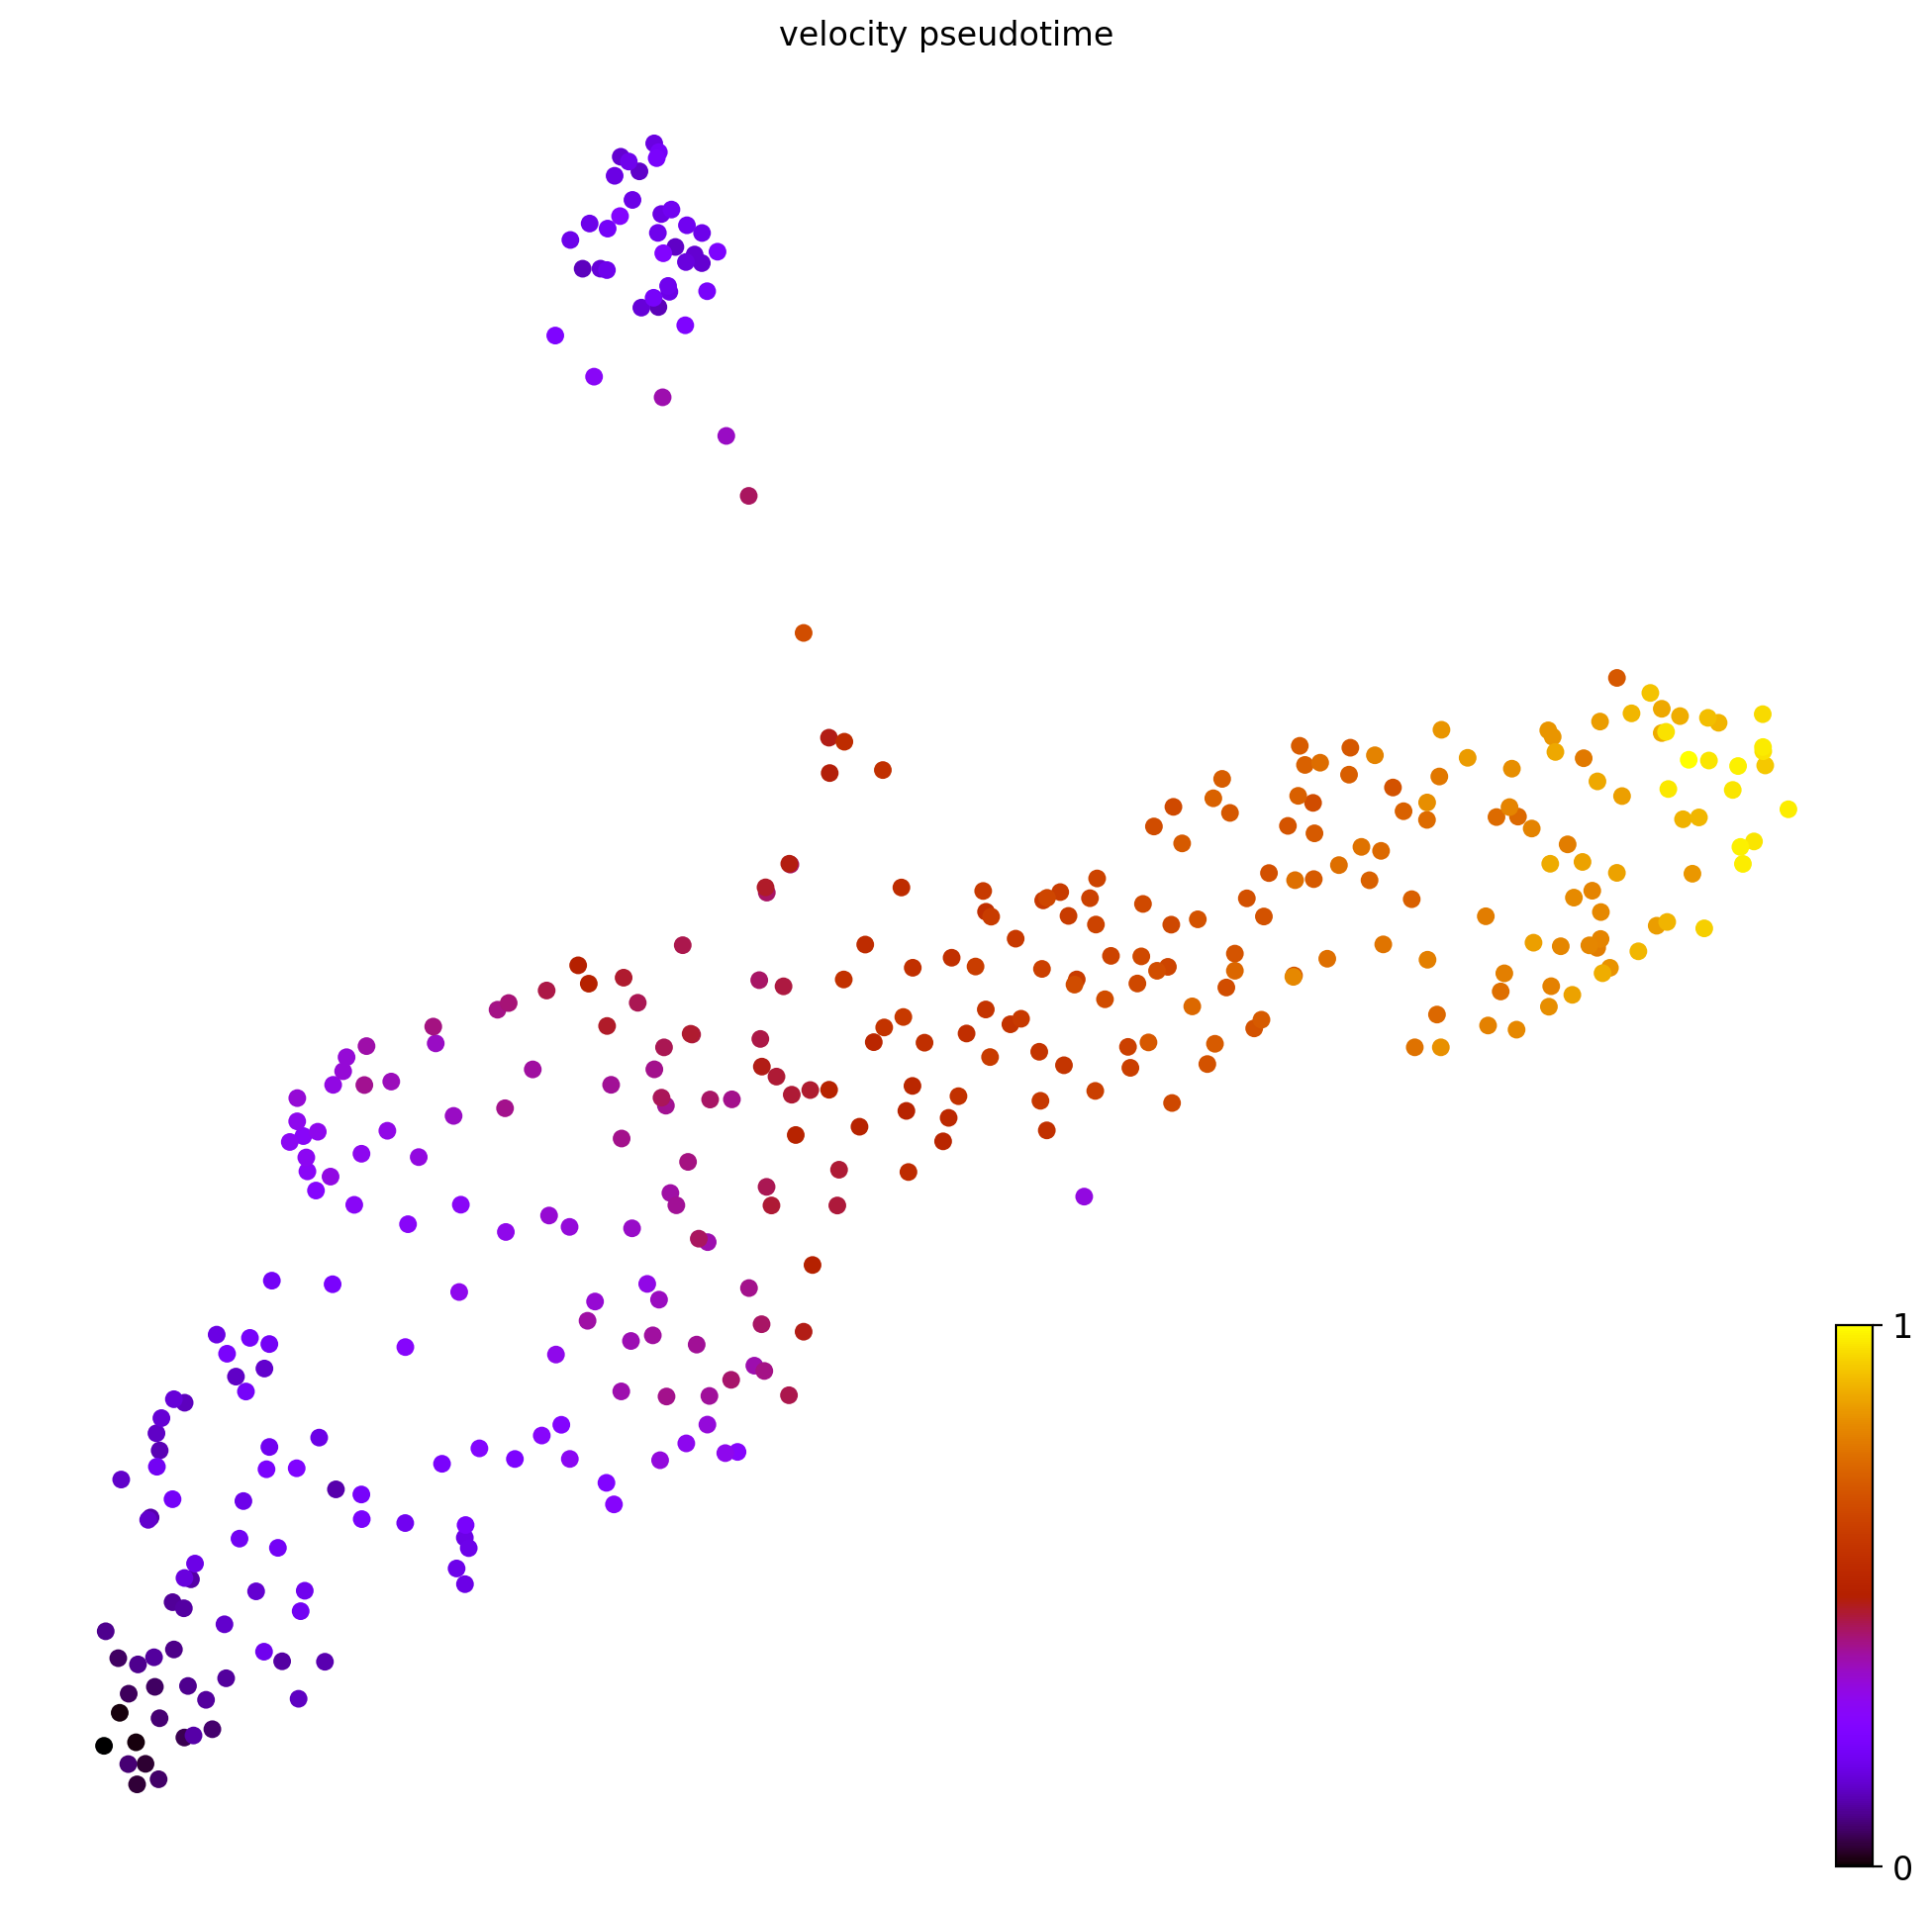

In [40]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### PAGA velocity graph
   - PAGAは、2つのクラスタ間の接続性に対応した重み付きエッジを用いて、データのトポロジーをグラフ化したようなマップを提供する

In [41]:
scv.tl.paga(adata, groups='louvain')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [42]:
df = scv.get_df(adata, 'paga/transitions_confidence').T

In [43]:
df.style.background_gradient(cmap='Blues').format('{:.2g}')

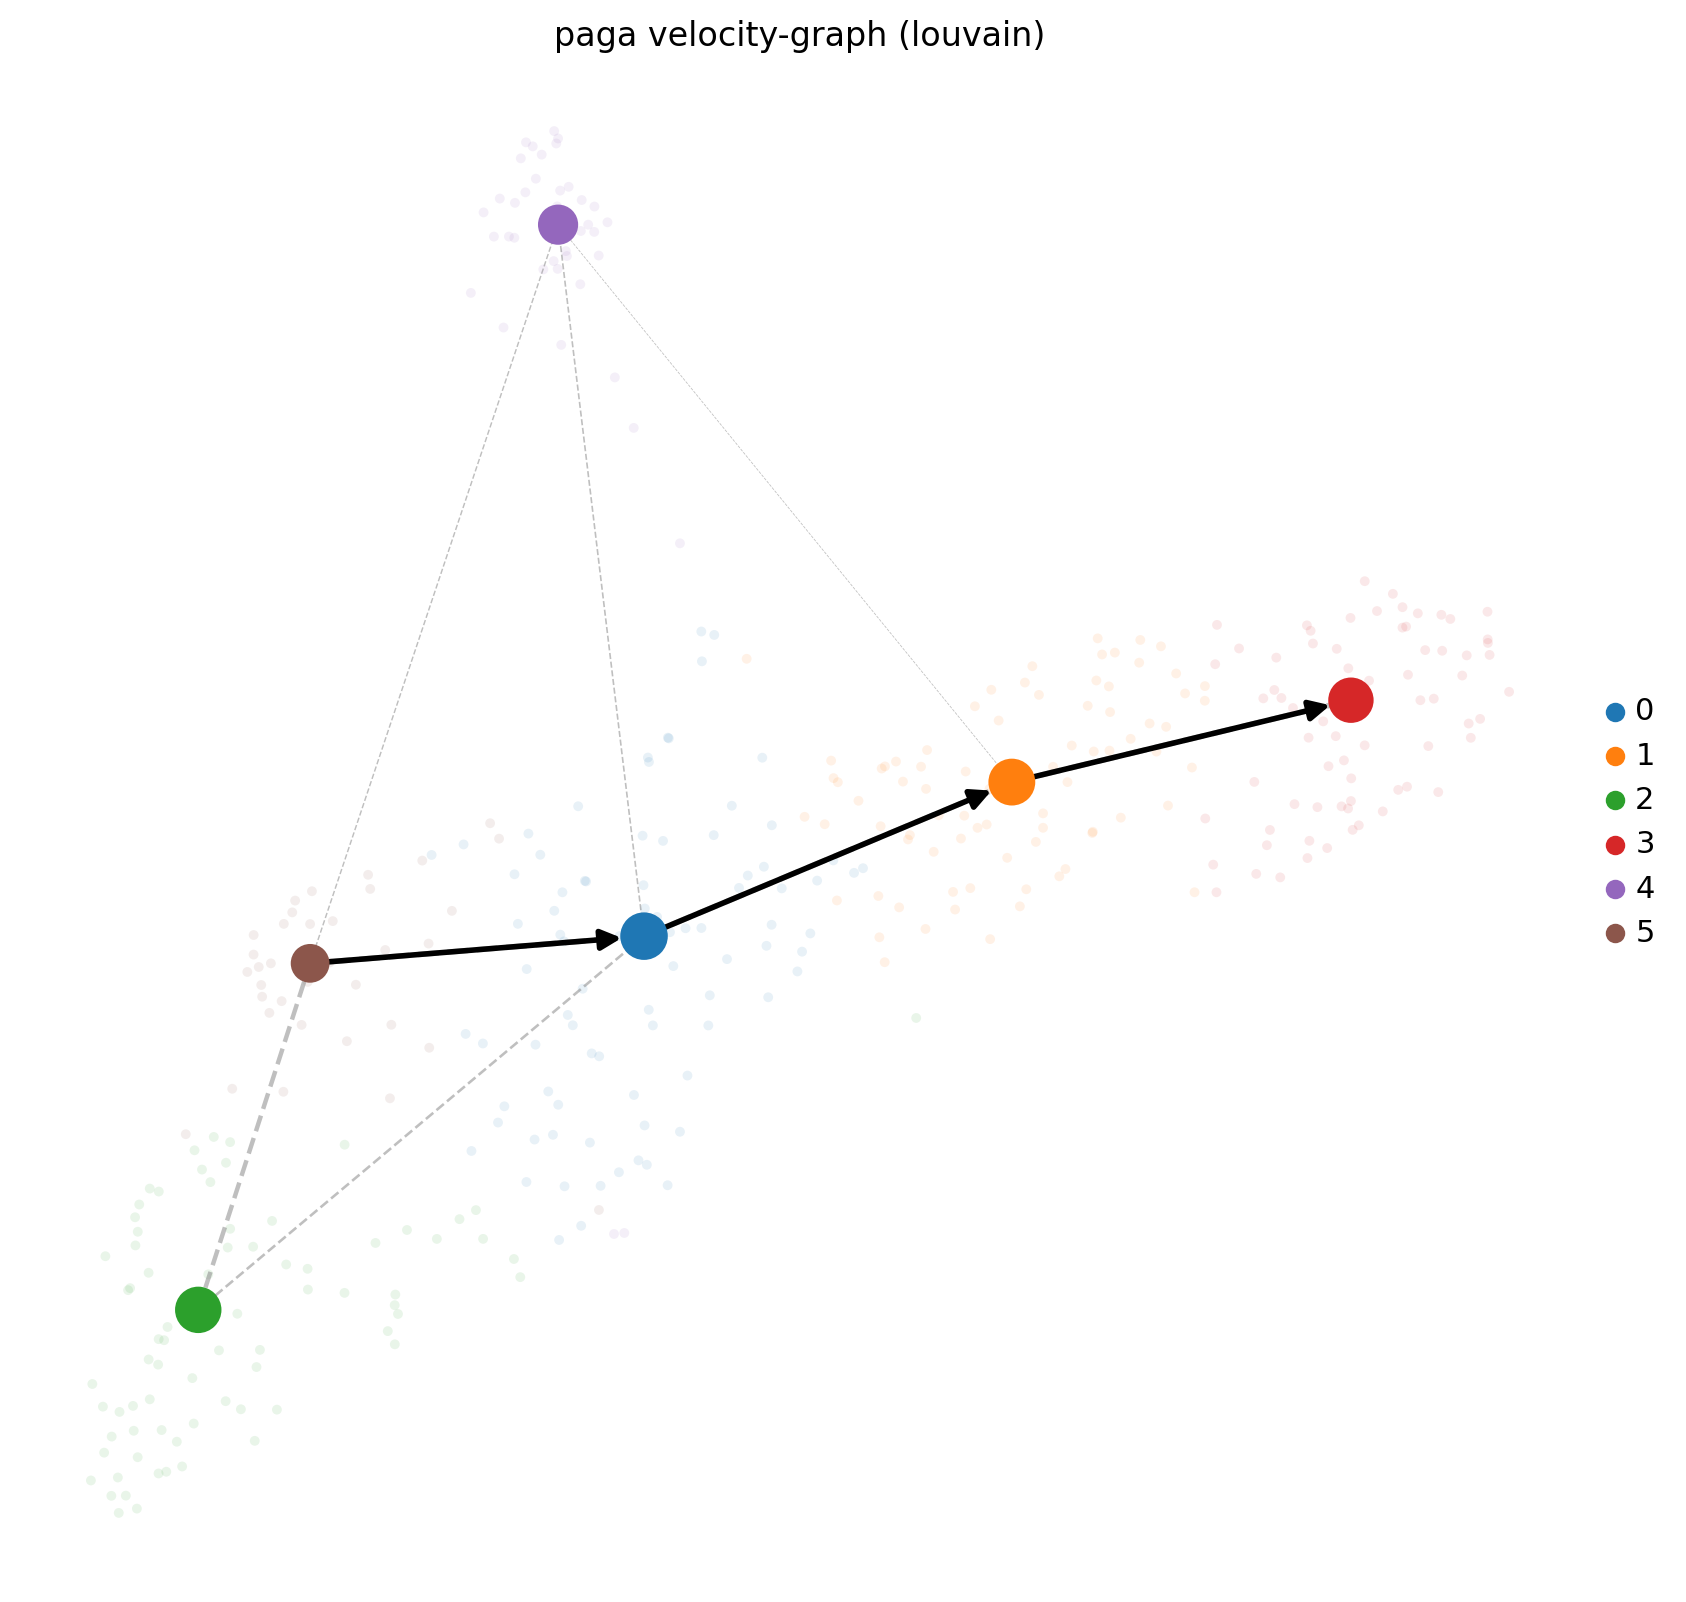

In [44]:
scv.pl.paga(adata, basis='umap',
            size=50,
            alpha=.1,
            min_edge_width=2,
            node_size_scale=1.5)

<br />
<hr>

## Smart-seq2データのVelocity解析のまとめ

- 決定論的モデルと確率論的モデルの2種類でVelocity推定を行った
- どちらも同じような低次元Velocity埋め込み結果になったが、シュワン細胞前駆体の結果は一致せず、遷移の信頼性も低かった
    - 他クラスタに比べて、シュワン細胞前駆体のVelocityは推定しにくい可能性
    - 元のvelocyto論文でのtSNEへの埋め込みプロットでも、シュワン細胞前駆体SCPのVelocityベクトル方向はバラバラだった
- Velocityはあくまで「スプライシングダイナミクスに基づく細胞の未来の状態予想」であり、分化系譜と必ずしも一致するとは限らないことは注意が必要